## Constraint function

In [1]:
import numpy as np
import tensorflow as tf
import scipy # need scipy 1.4.1 to work with GPyOpt
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import GPy
import GPyOpt_constraints
from GPyOpt_constraints.methods import BayesianOptimization
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
from pymc3 import Model, Normal, Slice, sample, traceplot
from pymc3.distributions import Interpolated
from scipy import stats
from theano import as_op

In [2]:
path='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/'
impath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/07_Figure_Graphs/Working_Folder/'
EI_drop_num=np.genfromtxt(path+'Dye_Set_EI_1/EI_drop_number.csv',delimiter=',')
MPI_drop_num=np.genfromtxt(path+'Dye_Set_MPI_1/MPI_drop_number.csv',delimiter=',')
LCB_drop_num=np.genfromtxt(path+'Dye_Set_LCB_1/LCB_drop_number.csv',delimiter=',')
drop_cat=np.concatenate((EI_drop_num,MPI_drop_num[20:],LCB_drop_num[20:]),axis=0)
drop_num=EI_drop_num # EI maps the cumulative of all 3 best. Plus EI has higher max droplet count than MPI (50 vs 30)
# grab all conditions + objective value + drop number
bo_full=pd.read_csv(path+'bo_full.csv',delimiter=',')
bo_full['DropCount']=drop_cat[:,3]
bo_full

Sample           Batch Method  Pressure  Frequency  Speed  Objective  \
0         1  Initialization    LHS     0.583      0.719  0.002      1.000   
1         2  Initialization    LHS     0.917      0.294  0.059      1.000   
2         3  Initialization    LHS     0.667      0.552  0.118      1.000   
3         4  Initialization    LHS     0.333      0.927  0.165      1.000   
4         5  Initialization    LHS     0.083      0.169  0.226      1.000   
..      ...             ...    ...       ...        ...    ...        ...   
135     136         Batch 4    LCB     1.000      1.000  1.000      1.000   
136     137         Batch 4    LCB     0.000      0.869  0.068      1.000   
137     138         Batch 4    LCB     0.250      0.065  0.992      0.569   
138     139         Batch 4    LCB     0.000      0.050  0.016      1.000   
139     140         Batch 4    LCB     0.917      0.009  0.848      0.746   

     DropCount  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
..         ...  
135        0.0  
136        0.0  
137       36.0  
138        0.0  
139        7.0  

[140 rows x 8 columns]

## Definitions

In [3]:
# create interpolation field and avoid singular matrix by removing repeating points
def interp_field(y_conds,x_conds):
    '''
    Inputs:
    xy_conds:=   Dx4 data array where the first 3 columns are pressure, frequency, speed 
                 and the 4th column are the y-values
    '''
    for n in range(3):
        cv_x_temp0=np.copy(x_conds[:,n])
        cv_x_temp1=np.copy(x_conds[:,(n+1)%3])
        cv_y_temp=np.copy(y_conds) # y condition
        for i in range(x_conds.shape[0]):
            for j in range(x_conds.shape[0]):
                if cv_x_temp0[i]==cv_x_temp0[j] and cv_x_temp1[i]==cv_x_temp1[j] and i!=j:
                    if cv_y_temp[i] < cv_y_temp[j]: # want to remove failed prints over good prints
                        cv_x_temp0[j]=np.nan
                        cv_x_temp1[j]=np.nan
                        cv_y_temp[j]=np.nan
                    else:
                        cv_x_temp0[i]=np.nan
                        cv_x_temp1[i]=np.nan
                        cv_y_temp[i]=np.nan
        cv_x_temp0=cv_x_temp0[~np.isnan(cv_x_temp0)]
        cv_x_temp1=cv_x_temp1[~np.isnan(cv_x_temp1)]
        cv_y_temp=cv_y_temp[~np.isnan(cv_y_temp)]
        globals()['rbf_'+str(n)]=Rbf(cv_x_temp0,cv_x_temp1,cv_y_temp,function='linear')
    return rbf_0, rbf_1, rbf_2
def interp_values(x_predict,y_all,x_all):
    '''
    x_predict :=    [x1,x2,x3] conditions to predict an output value
    y_all     :=    1D array of values to interpolate
    x_all     :=    Nx3 arry of conditions to use to interpolate y_all
    '''
    rbf_0,rbf_1,rbf_2=interp_field(y_conds=y_all,x_conds=x_all) # get interpolation fields in 2D slice
    val=np.array([rbf_0(x_predict[0],x_predict[1]),rbf_1(x_predict[1],x_predict[2]),rbf_2(x_predict[2],x_predict[0])]) # predict
    val = np.mean(val, axis = 0) # linearly interpolate predicted values
    val[val < 0.] = 0. # set all negative values equal to 0
    return val
# normalization function
def normalize_it(array):
    return (array - np.min(array))/((np.max(array-np.min(array))))
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition(x_conds,y_conds,constraint_function):
    '''
    Output the aquisition function so it can be augmented by the constraint function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         constraint_function=constraint_function[n,:,:],
                                         acquisition_type ='constrained_EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO(x_conds,y_conds,constraint_function):
    '''
    Implement Bayesian optimization.
    
    ** constraint_function must be a numpy array of shape (3,100,100) for 3D using three 2D surfaces
        and (100,100) for 2D.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     constraint_function=constraint_function, # must be a numpy array of three 2D surfaces with shape (3,100,100)
                                     acquisition_type ='constrained_EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next
# create new prior from the previous posteriors by interpolating the distributions
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition_reg(x_conds,y_conds):
    '''
    Output the aquisition function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         acquisition_type ='EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO_reg(x_conds,y_conds):
    '''
    Implement Bayesian optimization.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next

In [4]:
# Grab initialization data only
output_obj=np.array(bo_full['Objective'][:20]) # objective value
output_drops=np.array(bo_full['DropCount'][:20]) # number of droplets
pressure=np.array(bo_full['Pressure'][:20])
frequency=np.array(bo_full['Frequency'][:20])
speed=np.array(bo_full['Speed'][:20])
# start conditions lists
x_conds = [np.array([pressure,frequency,speed]).T] # X conditions
y_obj = [output_obj] # Objective values
y_cnt = [output_drops] # Number of droplets
# get meshgrid for plotting
xx, yy = [np.linspace(0,1,100),np.linspace(0,1,100)] # MESH SIZE MUST BE 100X100 IN ORDER FOR CONSTRAINT FUNCTION TO WORK IN BO LOOP
XX, YY = np.meshgrid (xx,yy)

# Initialize BO + Constraints

## Initialize constraint function priors using moderately-informed priors


I am aiming to reverse-engineer priors from the relationships between inputs-outputs.

First, the KDE is plotted for the LHS initialized data for pressure-ouput, frequency-output, speed-output.

Using the KDE visualization, I create a generative model for each input condition which generates similarly distributed droplet count values given inputs $\in[0,1]$

Then I create a model using those priors for our constraint function (the number of droplets)

### Continuous priors in pymc3

https://docs.pymc.io/api/distributions/continuous.html

In [5]:
# definition to plot kernel density estimation from scatter points
def density_estimation(m1, m2):
    xmin=np.min(m1)
    xmax=np.max(m1)
    ymin=np.min(m2)
    ymax=np.max(m2)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

#### Pressure priors in 1D

In [6]:
with pm.Model() as pressure_model:
    alpha0=pm.Uniform('alpha0',lower=0,upper=40) #bias
    alpha1=pm.Gamma('alpha1',alpha=0.7,beta=0.5)
pressure_trace=pm.sample(1000,model=pressure_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha1, alpha0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'Informative Prior Distribution\nU(0,40)*Gamma(0.7,0.5)\n')

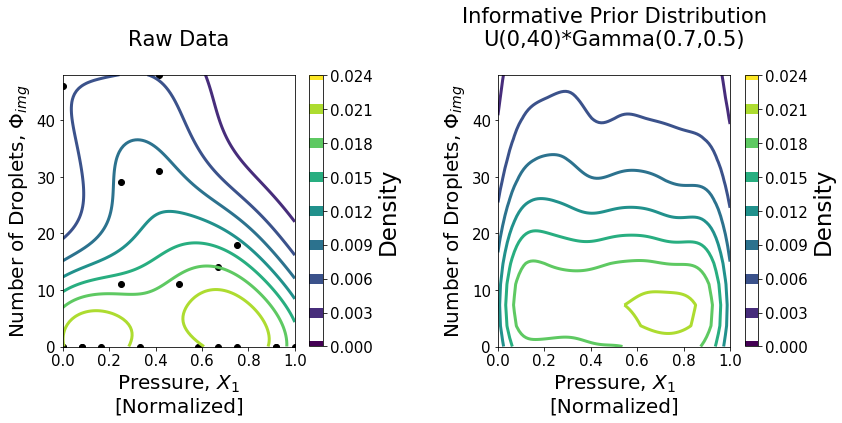

In [7]:
# Model pressure vs droplet count with continuous distributions
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(13,5))
plt.subplots_adjust(wspace=0.5)
val0=pressure
X0, Y0, Z0 = density_estimation(val0, output_drops)
pl1=ax1.contour(X0,Y0,Z0,linewidths=3)
ax1.scatter(val0,output_drops,c='k')
cbar1=fig.colorbar(pl1,ax=ax1)
cbar1.ax.tick_params(labelsize=15) 
cbar1.set_label('Density',size=23)
cbar1.lines[0].set_linewidth(10)
ax1.set_ylim([0,np.max(output_drops)])
ax1.set_xlim([0,1])
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Pressure, $X_1$\n[Normalized]',size=20)
ax1.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax1.set_title('Raw Data\n',size=21)


out0,out1=pressure_trace['alpha0'],pressure_trace['alpha1']
out=out0*out1
val1=np.linspace(0.0,1,len(out))
X1, Y1, Z1 = density_estimation(val1, out)
pl2=ax2.contour(X1,Y1,Z1,linewidths=3)
cbar2=fig.colorbar(pl2,ax=ax2)
cbar2.ax.tick_params(labelsize=15) 
cbar2.set_label('Density',size=23)
cbar2.lines[0].set_linewidth(10)
ax2.set_ylim([0,np.max(output_drops)])
ax2.set_xlim([0,1])
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Pressure, $X_1$\n[Normalized]',size=20)
ax2.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax2.set_title('Informative Prior Distribution\nU(0,40)*Gamma(0.7,0.5)\n',size=21)

#### Frequency priors in 1D

In [8]:
with pm.Model() as frequency_model:
    beta0=pm.Uniform('beta0',lower=0,upper=90) #bias
    beta1=pm.Gamma('beta1',alpha=0.7,beta=0.5)
frequency_trace=pm.sample(1000,model=frequency_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'Informative Prior Distribution\nU(0,90)*Gamma(0.7,0.5)*($0.7-X_2$)\n')

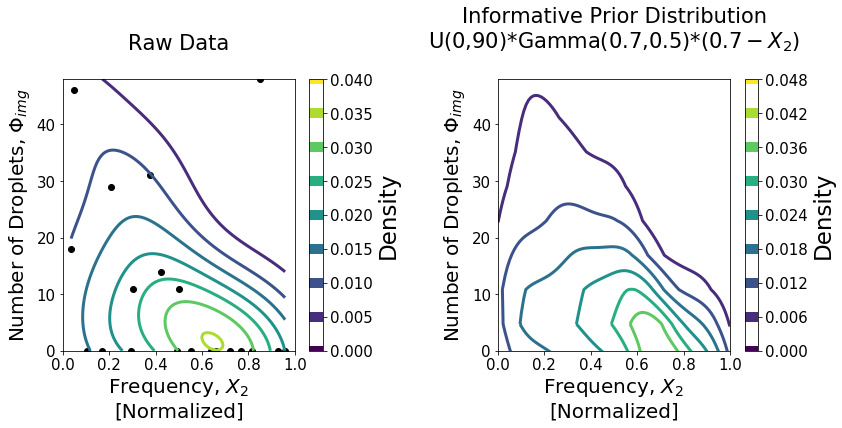

In [9]:
# Model frequency vs droplet count with continuous distributions
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(13,5))
plt.subplots_adjust(wspace=0.5)
val0=frequency
X0, Y0, Z0 = density_estimation(val0, output_drops)
pl1=ax1.contour(X0,Y0,Z0,linewidths=3)
ax1.scatter(val0,output_drops,c='k')
cbar1=fig.colorbar(pl1,ax=ax1)
cbar1.ax.tick_params(labelsize=15) 
cbar1.set_label('Density',size=23)
cbar1.lines[0].set_linewidth(10)
ax1.set_ylim([0,np.max(output_drops)])
ax1.set_xlim([0,1])
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Frequency, $X_2$\n[Normalized]',size=20)
ax1.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax1.set_title('Raw Data\n',size=21)


out0,out1=frequency_trace['beta0'],frequency_trace['beta1']
out=out0*out1*(0.7-val1)
val1=np.linspace(0.0,1,len(out))
X1, Y1, Z1 = density_estimation(val1, out)
pl2=ax2.contour(X1,Y1,Z1,linewidths=3)
cbar2=fig.colorbar(pl2,ax=ax2)
cbar2.ax.tick_params(labelsize=15) 
cbar2.set_label('Density',size=23)
cbar2.lines[0].set_linewidth(10)
ax2.set_ylim([0,np.max(output_drops)])
ax2.set_xlim([0,1])
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Frequency, $X_2$\n[Normalized]',size=20)
ax2.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax2.set_title('Informative Prior Distribution\nU(0,90)*Gamma(0.7,0.5)*($0.7-X_2$)\n',size=21)

#### Speed priors in 1D

In [10]:
with pm.Model() as speed_model:
    gamma0=pm.Uniform('gamma0',lower=0,upper=90) #bias
    gamma1=pm.Gamma('gamma1',alpha=0.7,beta=0.5)
speed_trace=pm.sample(1000,model=speed_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma1, gamma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'Informative Prior Distribution\nU(0,90)*Gamma(0.7,0.5)*($X_3-0.2$)\n')

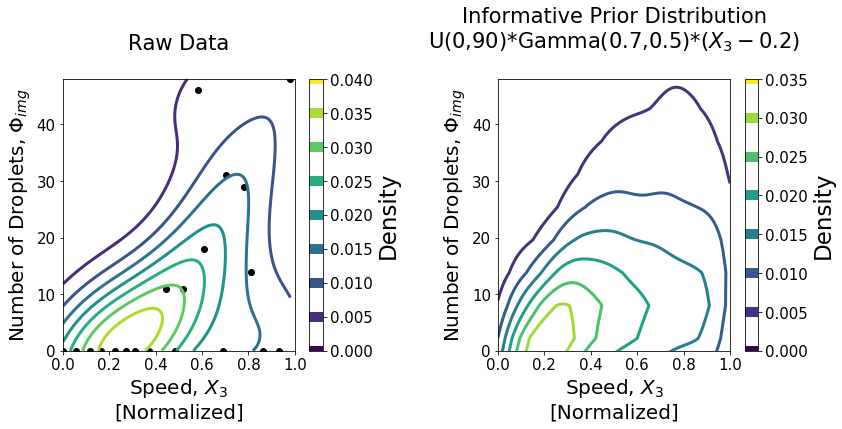

In [11]:
# Model speed vs droplet count with continuous distributions
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(13,5))
plt.subplots_adjust(wspace=0.5)
val0=speed
X0, Y0, Z0 = density_estimation(val0, output_drops)
pl1=ax1.contour(X0,Y0,Z0,linewidths=3)
ax1.scatter(val0,output_drops,c='k')
cbar1=fig.colorbar(pl1,ax=ax1)
cbar1.ax.tick_params(labelsize=15) 
cbar1.set_label('Density',size=23)
cbar1.lines[0].set_linewidth(10)
ax1.set_ylim([0,np.max(output_drops)])
ax1.set_xlim([0,1])
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Speed, $X_3$\n[Normalized]',size=20)
ax1.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax1.set_title('Raw Data\n',size=21)


out0,out1=speed_trace['gamma0'],speed_trace['gamma1']
out=out0*out1*(val1-0.2)
val1=np.linspace(0.0,1,len(out))
X1, Y1, Z1 = density_estimation(val1, out)
pl2=ax2.contour(X1,Y1,Z1,linewidths=3)
cbar2=fig.colorbar(pl2,ax=ax2)
cbar2.ax.tick_params(labelsize=15) 
cbar2.set_label('Density',size=23)
cbar2.lines[0].set_linewidth(10)
ax2.set_ylim([0,np.max(output_drops)])
ax2.set_xlim([0,1])
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Speed, $X_3$\n[Normalized]',size=20)
ax2.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax2.set_title('Informative Prior Distribution\nU(0,90)*Gamma(0.7,0.5)*($X_3-0.2$)\n',size=21)

## Build initialization model from the moderately-informed priors

In [12]:
# initialize model priors
traces = [] # create list to append traces of priors
init_model = Model()
with init_model:
    # Priors for unknown model parameters
    alpha1 = pm.Normal("alpha1", mu=0, sigma=1)
    alpha2 = pm.Normal("alpha2", mu=0, sigma=1)
    alpha3 = pm.Normal("alpha3", mu=0, sigma=1)
    beta1 = pm.Gamma("beta1", alpha=0.7, beta=0.5)
    beta2 = pm.Gamma("beta2", alpha=0.7, beta=0.5)
    beta3 = pm.Gamma("beta3", alpha=0.7, beta=0.5)
    
    # Expected value of outcome
    mu1 = alpha1 + beta1 * pressure + beta2 * (0.7-frequency) # pressure-frequency
    mu2 = alpha2 + beta2 * (0.7-frequency) + beta3 * (speed-0.2) # frequency-speed
    mu3 = alpha3 + beta3 * (speed-0.2) + beta1 * pressure # speed-pressure

    # Likelihood (sampling distribution) of observations
    Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=y_cnt[0])
    Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=y_cnt[0])
    Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=y_cnt[0])

    # draw 1000 posterior samples using HMC
    trace = sample(1000)
    traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


In [13]:
# compute simulated droplet numbers for each 2D slice
X_sim=np.linspace(0,1,len(trace['alpha1']))
Y_pf = trace['alpha1']+trace['beta1']*X_sim+trace['beta2']*(0.7-X_sim)
# Y_pf_norm = normalize_it(Y_pressure_frequency) # normalize
Y_fs = trace['alpha2']+trace['beta2']*(0.7-X_sim)+trace['beta3']*(X_sim-0.2)
# Y_fs_norm = normalize_it(Y_frequency_speed) # normalize
Y_sp = trace['alpha3']+trace['beta1']*X_sim+trace['beta3']*(X_sim-0.2)
# Y_sp_norm = normalize_it(Y_speed_pressure) # normalize

# run interpolation
dropnum_2Ds=[]
# pressure-frequency
rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
surf_f0=rbf_pf(XX,YY)
# frequency-speed
rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
surf_f1=rbf_fs(XX,YY)
# speed-pressure
rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
surf_f2=rbf_sp(XX,YY)
max_norm = np.max([surf_f0,surf_f1,surf_f2])
dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))

## Run first round of BO using the constraint function learned from LHS initialized data

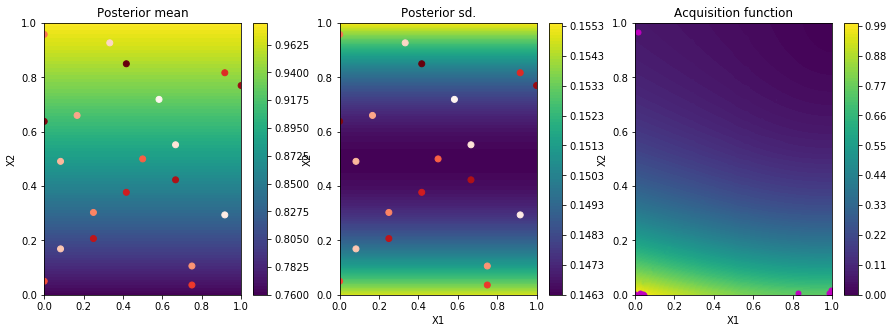

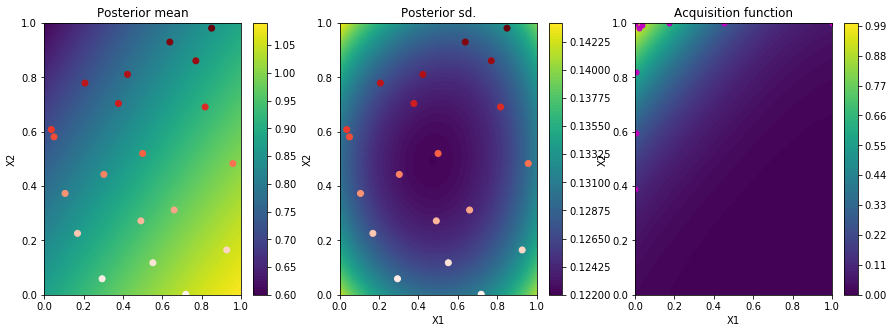

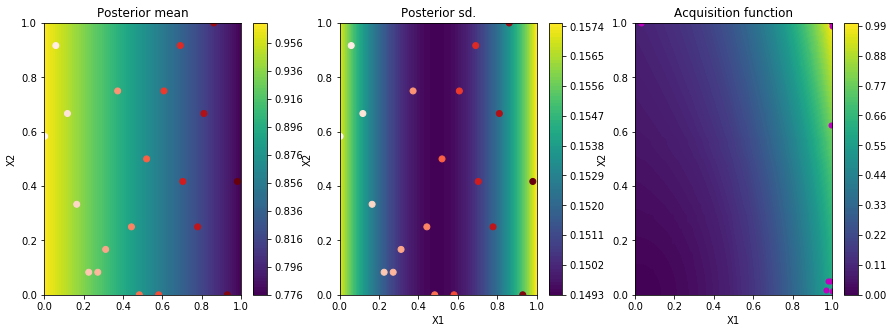

In [14]:
# RUN BO and get the new 10 output conditions using the the 20 LHS initialized conditions, objective values, and constraints
acq_2Ds=[] # list of acquisition function spaces
acq_2Ds.append(output_acquisition(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))
x_conds.append(run_BO(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))

# Update BO + Constraints

In [15]:
# all condition values
XS=np.array(bo_full[['Pressure','Frequency','Speed']])
Y_obj=np.array(bo_full['Objective'])
Y_cnt=np.array(bo_full['DropCount'])

 BO + Constraints Batch Update 1 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


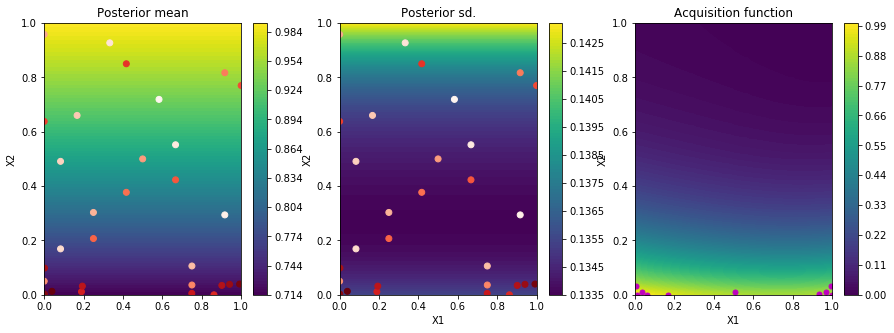

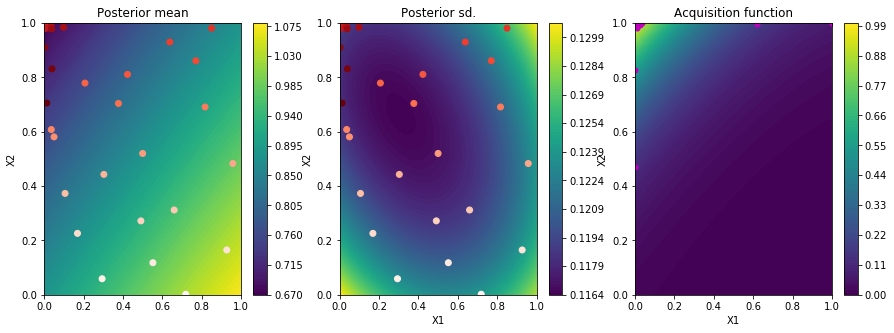

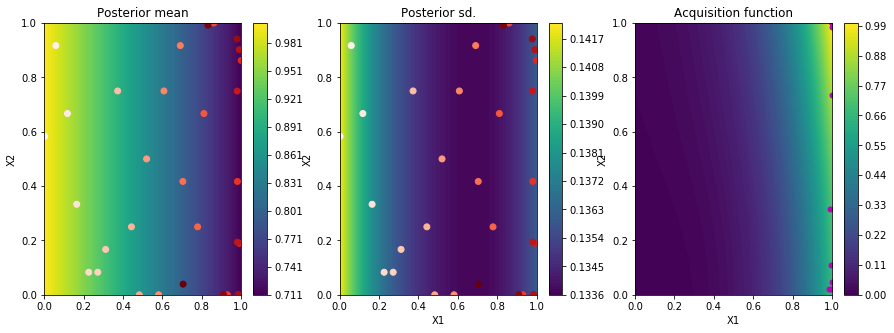

 BO + Constraints Batch Update 2 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


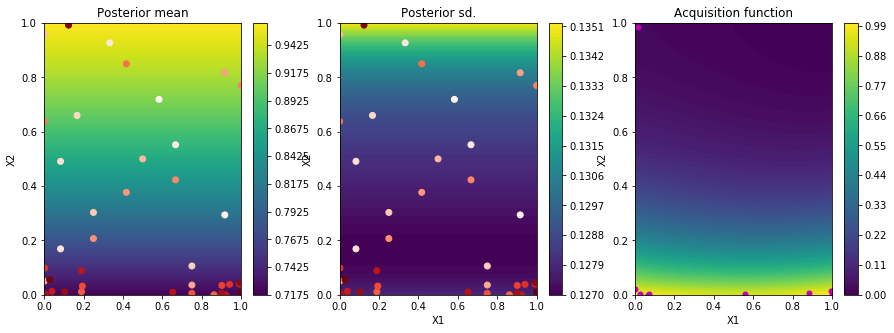

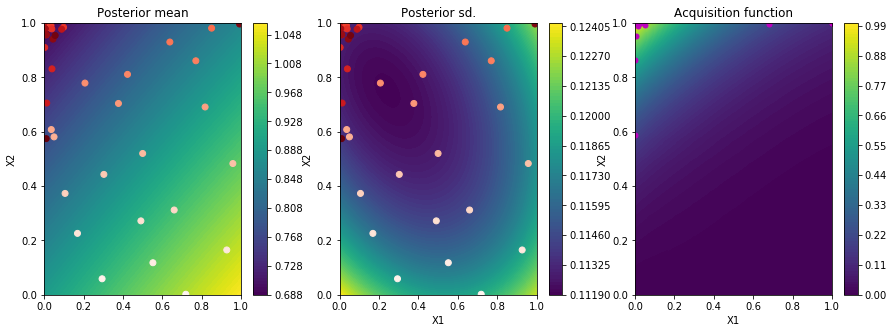

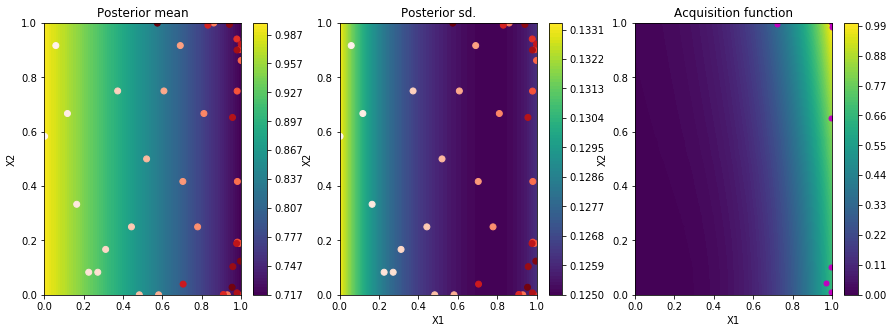

 BO + Constraints Batch Update 3 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The number of effective samples is smaller than 10% for some parameters.


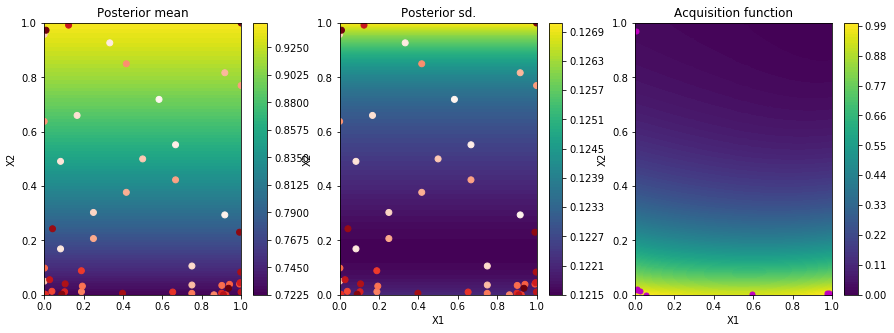

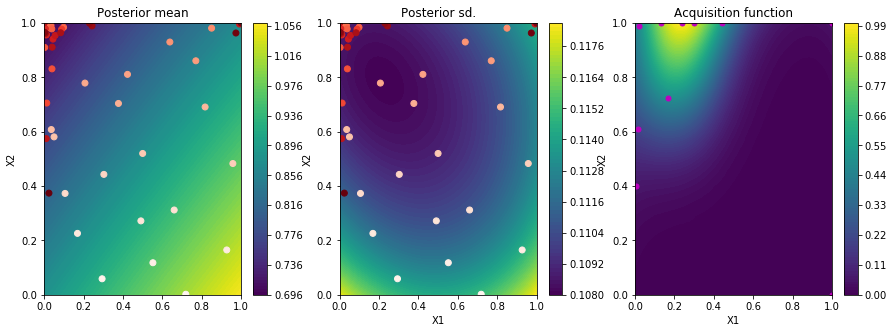

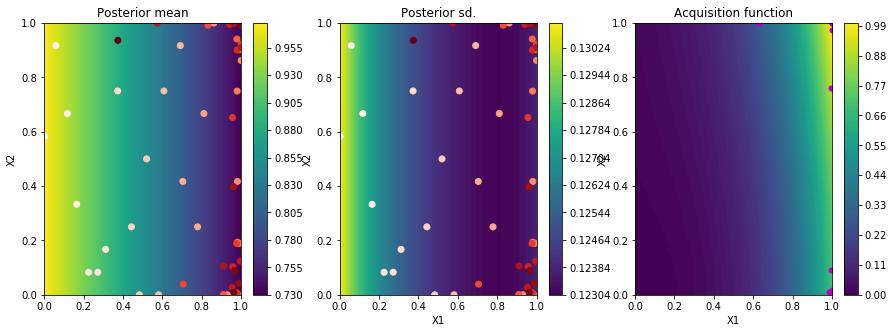

 BO + Constraints Batch Update 4 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


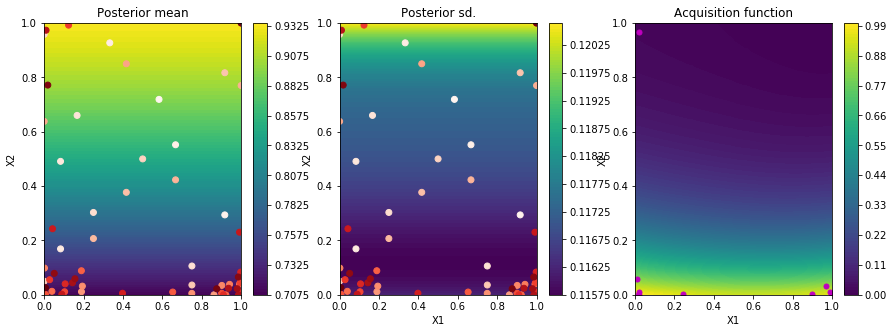

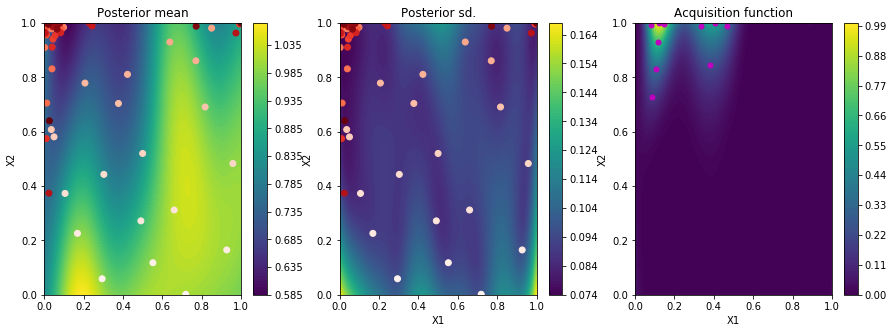

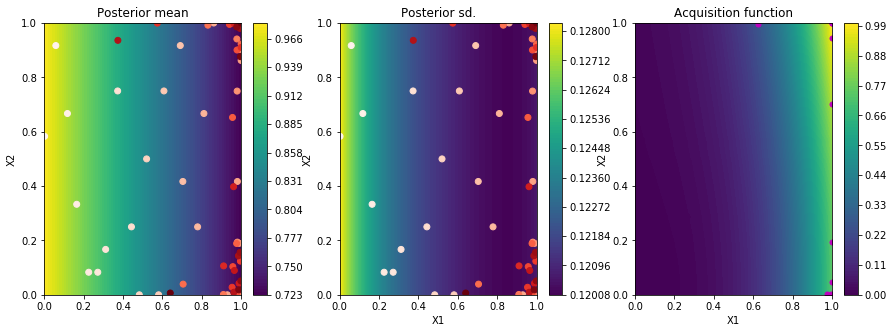

 BO + Constraints Batch Update 5 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
The number of effective samples is smaller than 25% for some parameters.


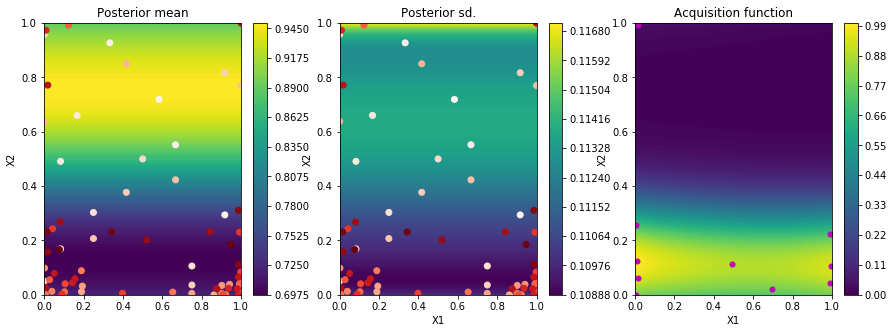

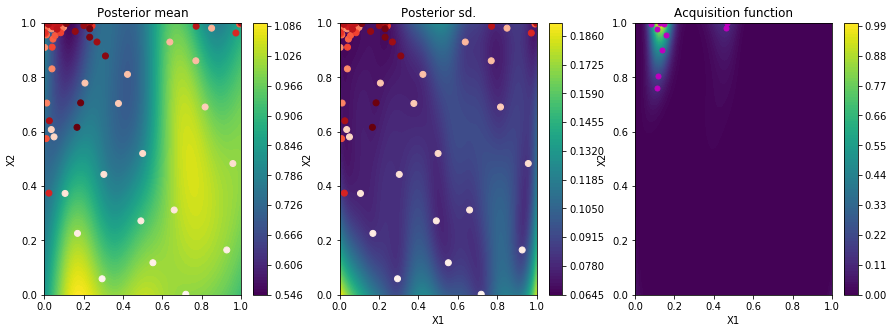

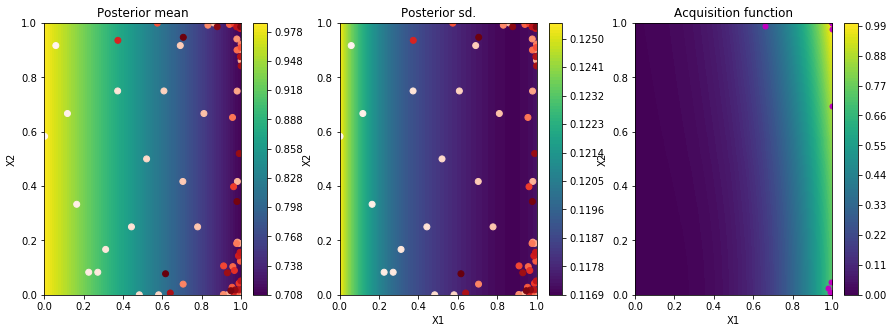

 BO + Constraints Batch Update 6 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


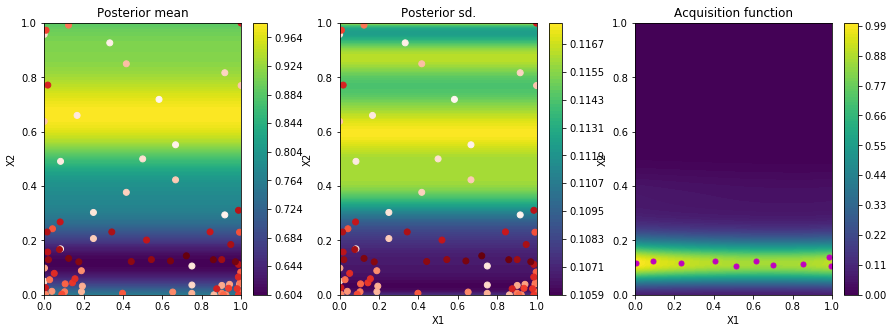

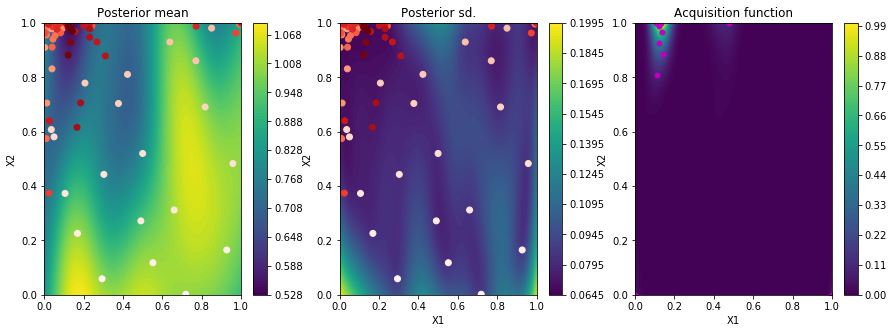

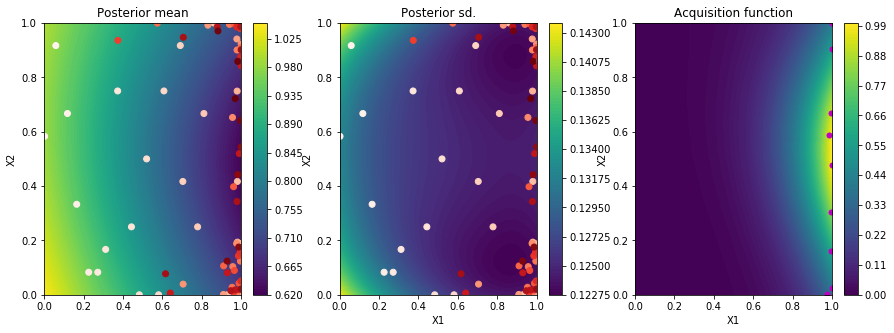

 BO + Constraints Batch Update 7 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5145736316086632, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.625008714764376, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


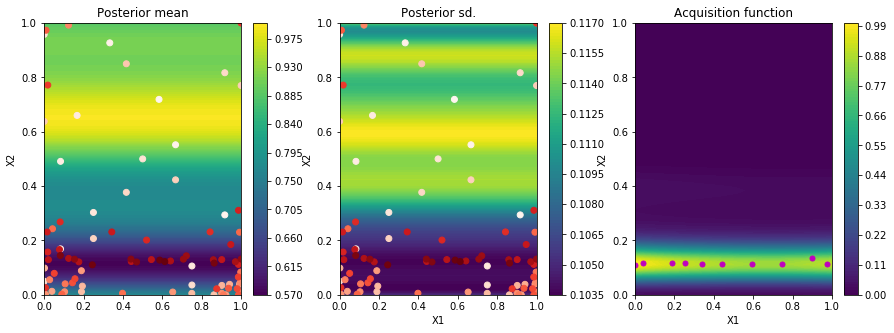

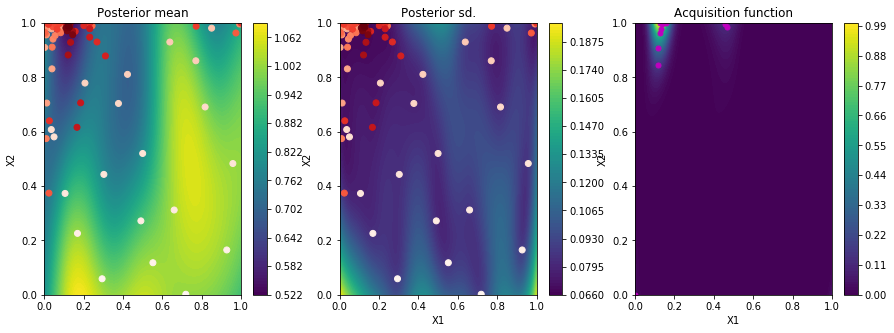

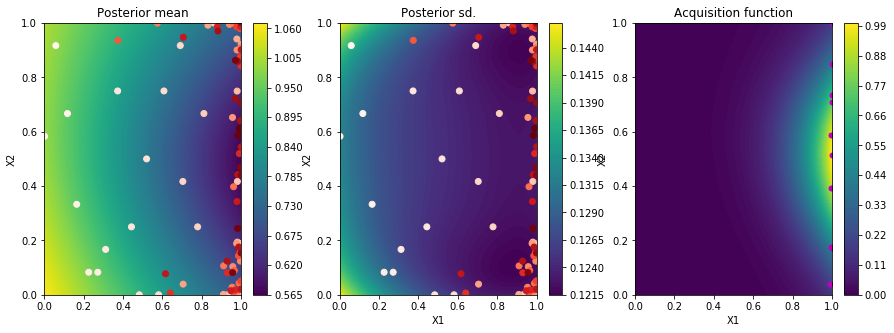

 BO + Constraints Batch Update 8 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


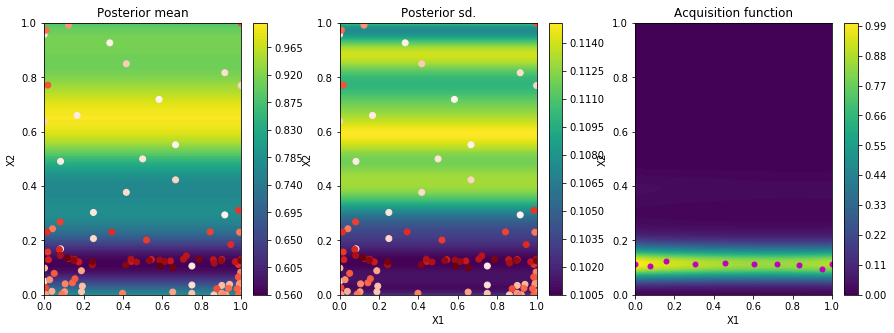

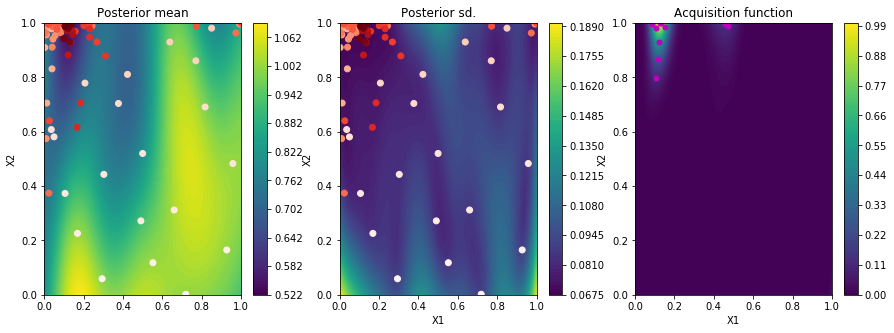

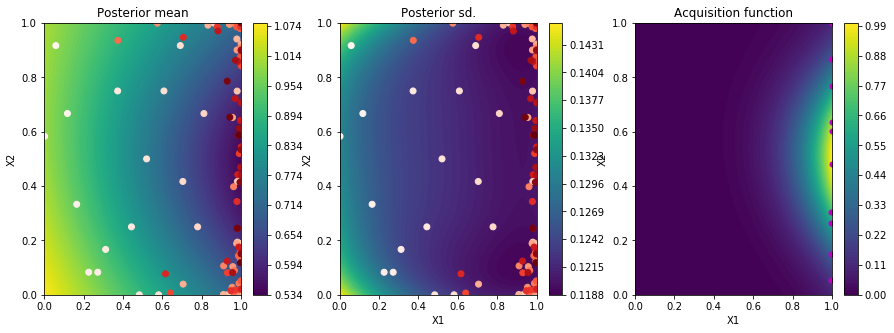

 BO + Constraints Batch Update 9 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The number of effective samples is smaller than 25% for some parameters.


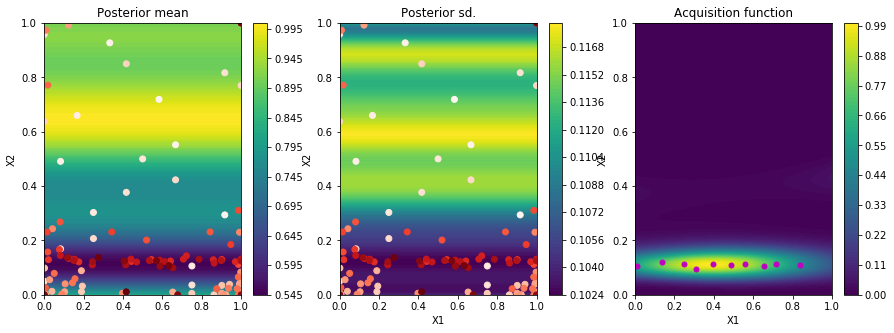

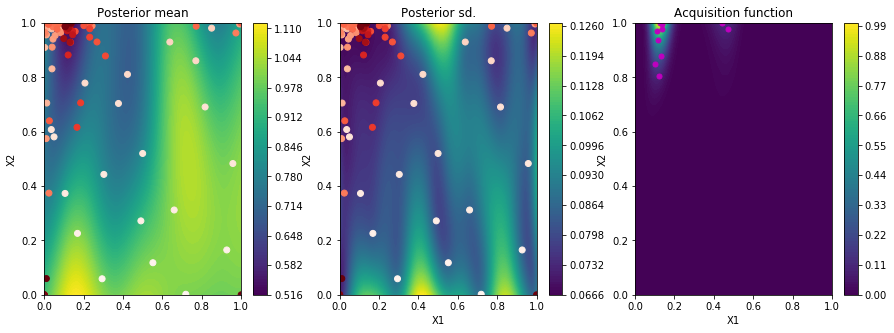

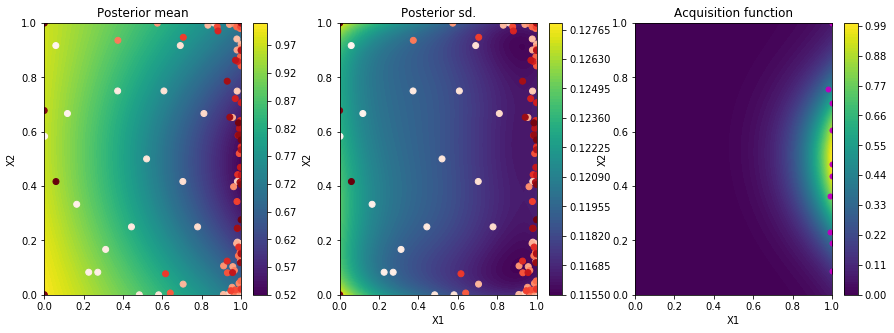

 BO + Constraints Batch Update 10 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The number of effective samples is smaller than 25% for some parameters.


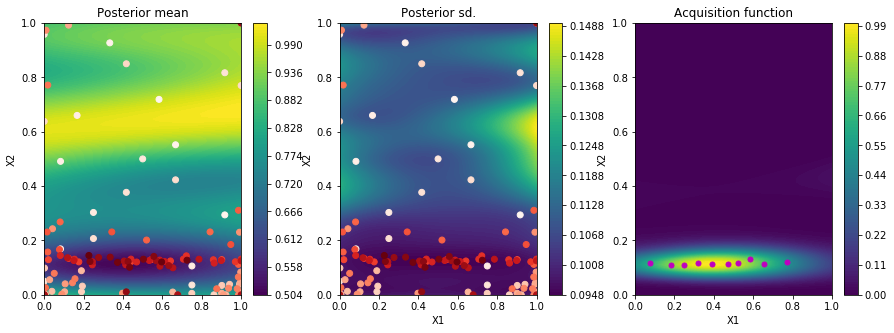

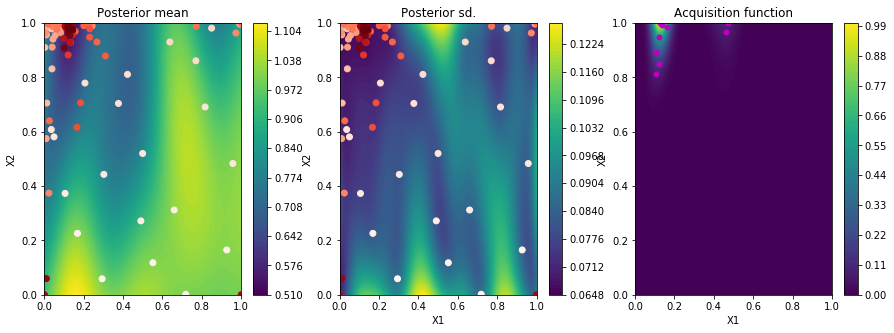

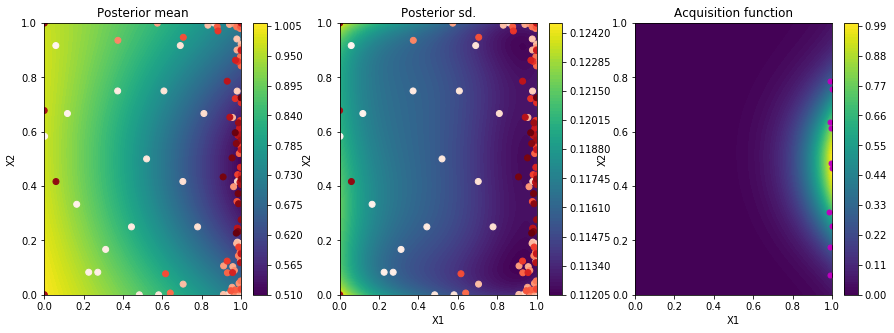

In [16]:
# Begin loop
# assign variables
Xp = x_conds[0][:,0] # pressure
Xf = x_conds[0][:,1] # frequency
Xs = x_conds[0][:,2] # speed
Yo = y_obj[0] # objective value
Yc = y_cnt[0] # droplet count
for i in range(10):
    print('','='*30,'\n BO + Constraints Batch Update '+str(i+1),'\n','='*30)
    # ==================================================================================
    # get interpolation field of objective value and droplet counts
    y_obj.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
    y_cnt.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_cnt, x_all = XS)) # use first batch after initilization
    # assign variables from first update
    Xp = np.concatenate((Xp, x_conds[i+1][:,0])) # pressure
    Xf = np.concatenate((Xf, x_conds[i+1][:,1])) # frequency
    Xs = np.concatenate((Xs, x_conds[i+1][:,2])) # speed
    Yo = np.concatenate((Yo, y_obj[i+1])) # objective value
    Yc = np.concatenate((Yc, y_cnt[i+1])) # droplet count
    # ==================================================================================
    # get new HMC estimations of droplet count priors to learn the constraint with the new y_cnt data from previous batch
    update_model = Model()
    with update_model:
        # Priors are posteriors from previous iteration
        alpha1 = from_posterior("alpha1", traces[i]["alpha1"])
        alpha2 = from_posterior("alpha2", traces[i]["alpha2"])
        alpha3 = from_posterior("alpha3", traces[i]["alpha3"])
        beta1 = from_posterior("beta1", traces[i]["beta1"])
        beta2 = from_posterior("beta2", traces[i]["beta2"])
        beta3 = from_posterior("beta3", traces[i]["beta3"])

        # Expected value of outcome
        mu1 = alpha1 + beta1 * Xp + beta2 * (0.7-Xf) # pressure-frequency
        mu2 = alpha2 + beta2 * (0.7-Xf) + beta3 * (Xs-0.2) # frequency-speed
        mu3 = alpha3 + beta3 * (Xs-0.2) + beta1 * Xp # speed-pressure
        
        # Likelihood (sampling distribution) of observations
        Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=Yc) # observed droplet count
        Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=Yc) # observed droplet count
        Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=Yc) # observed droplet count
        
        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)
    # ==================================================================================
    # compute simulated droplet numbers for each 2D slice
    Y_pf = traces[i+1]['alpha1']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta2']*(0.7-X_sim)
#     Y_pf_norm = normalize_it(Y_pressure_frequency)
    Y_fs = traces[i+1]['alpha2']+traces[i+1]['beta2']*(0.7-X_sim)+traces[i+1]['beta3']*(X_sim-0.2)
#     Y_fs_norm = normalize_it(Y_frequency_speed)
    Y_sp = traces[i+1]['alpha3']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta3']*(X_sim-0.2)
#     Y_sp_norm = normalize_it(Y_speed_pressure)
    # run interpolation
    # pressure-frequency
    rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
    surf_f0=rbf_pf(XX,YY)
    # frequency-speed
    rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
    surf_f1=rbf_fs(XX,YY)
    # speed-pressure
    rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
    surf_f2=rbf_sp(XX,YY)
    max_norm = np.max([surf_f0,surf_f1,surf_f2])
    dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))
    # ==================================================================================
    # Run BO batch
    acq_2Ds.append(output_acquisition(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get 2D acquisition slices soley for plotting cubes
    x_conds.append(run_BO(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get new x-condition optima

# Regular BO

 Regular BO Batch Update 1 


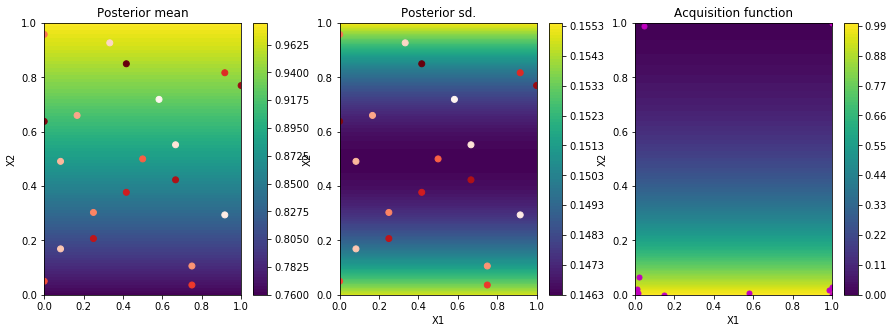

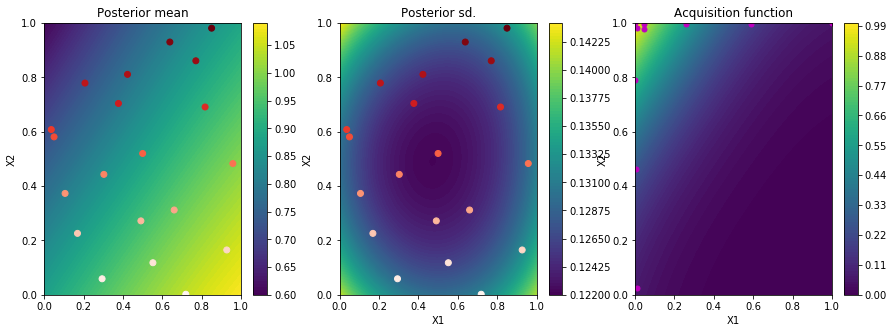

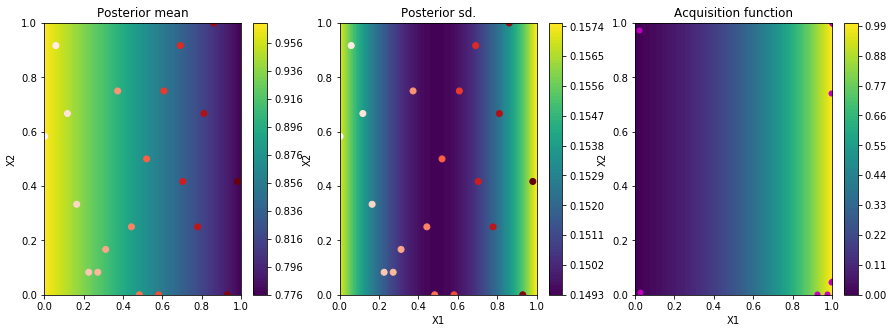

 Regular BO Batch Update 2 


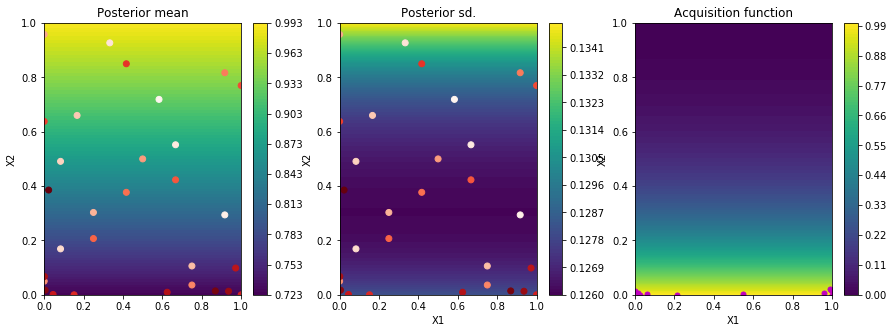

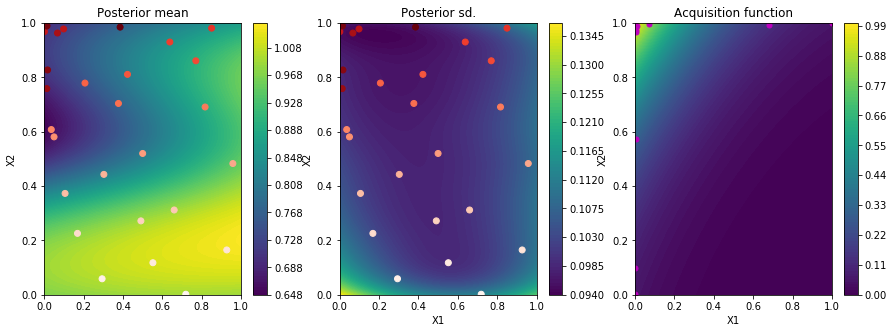

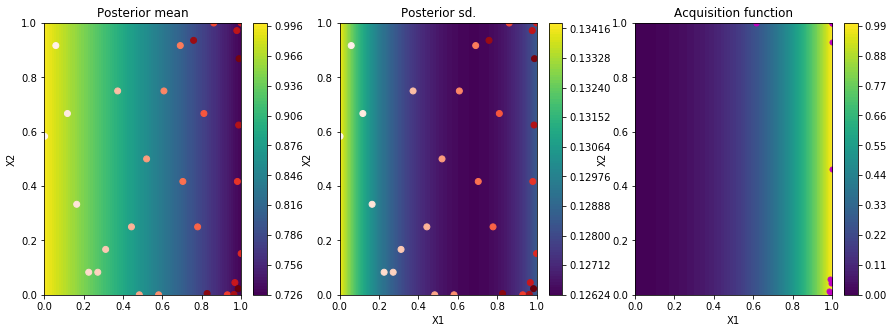

 Regular BO Batch Update 3 


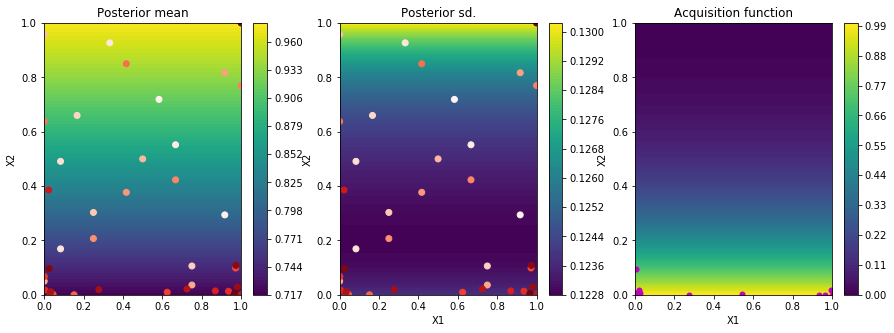

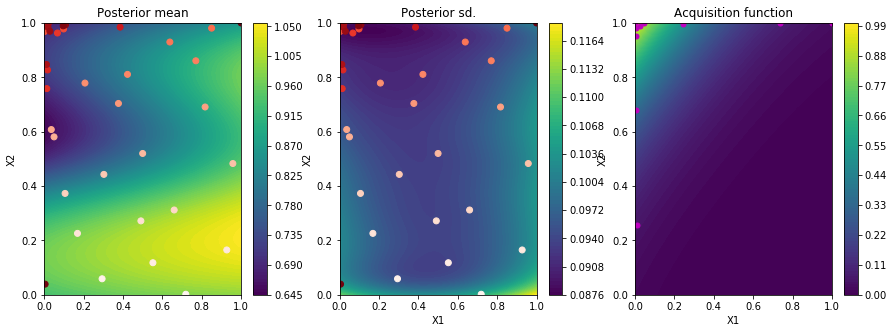

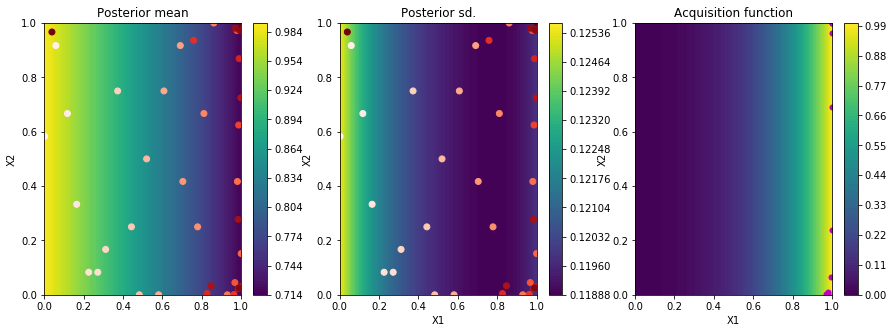

 Regular BO Batch Update 4 


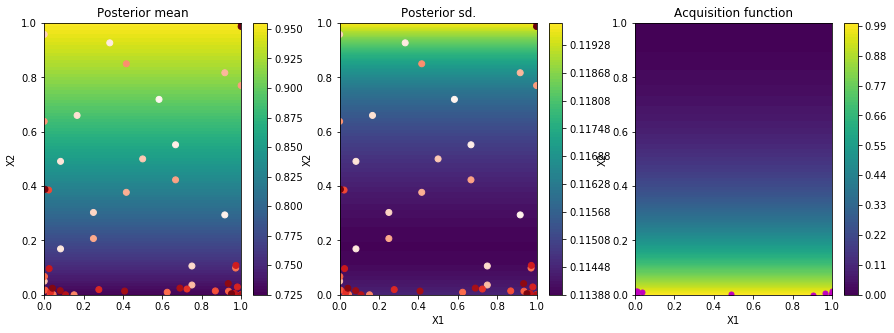

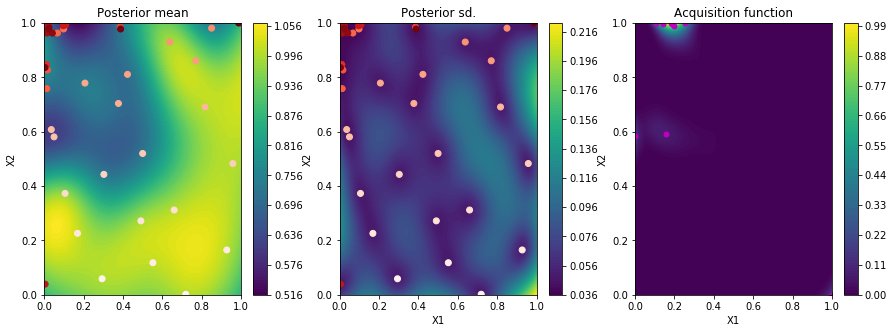

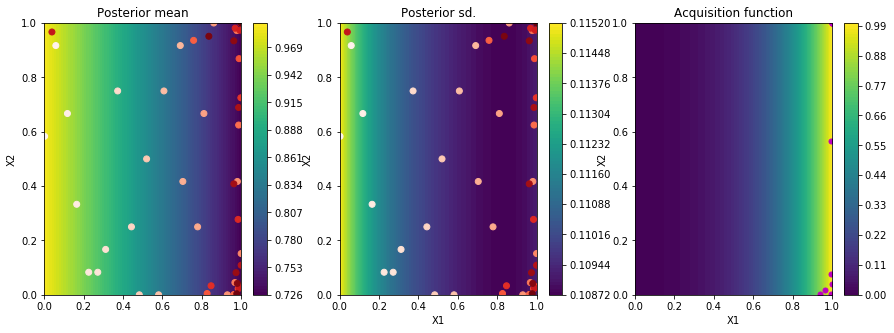

 Regular BO Batch Update 5 


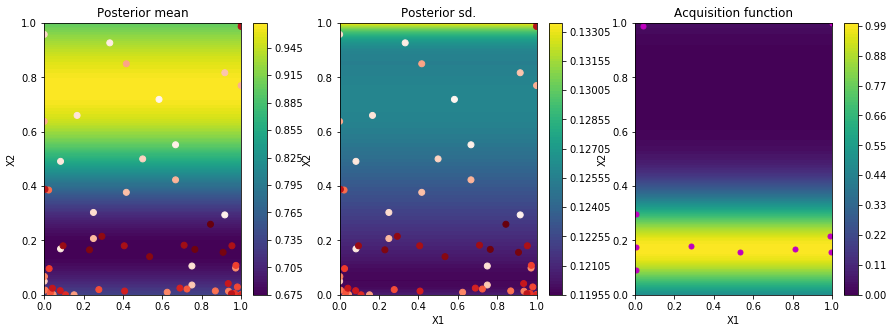

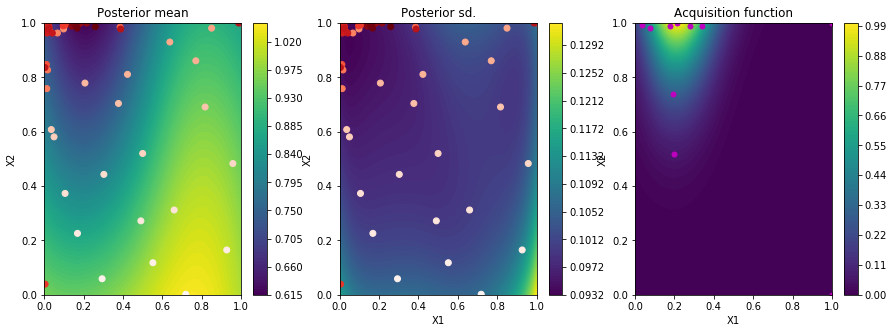

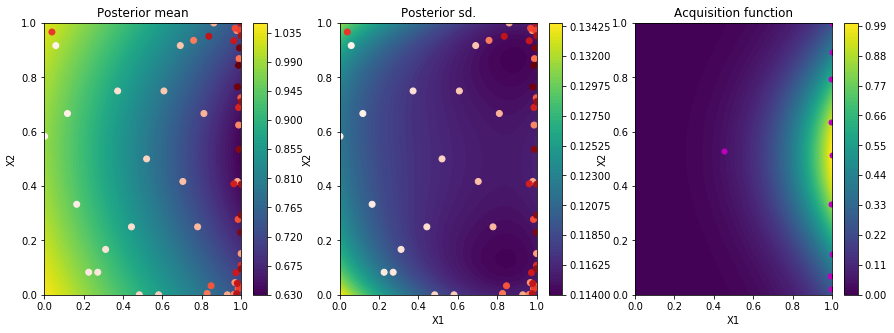

 Regular BO Batch Update 6 


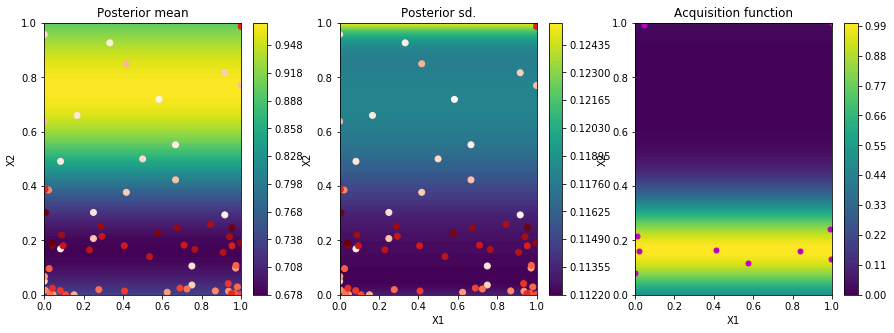

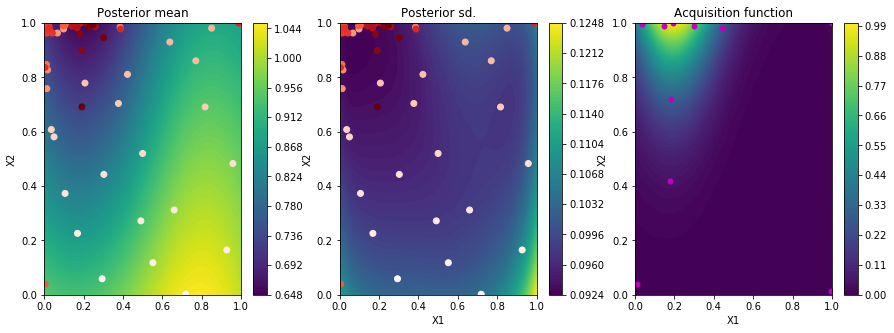

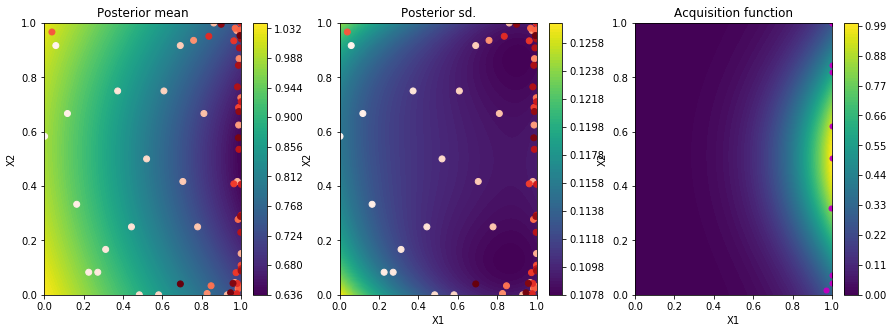

 Regular BO Batch Update 7 


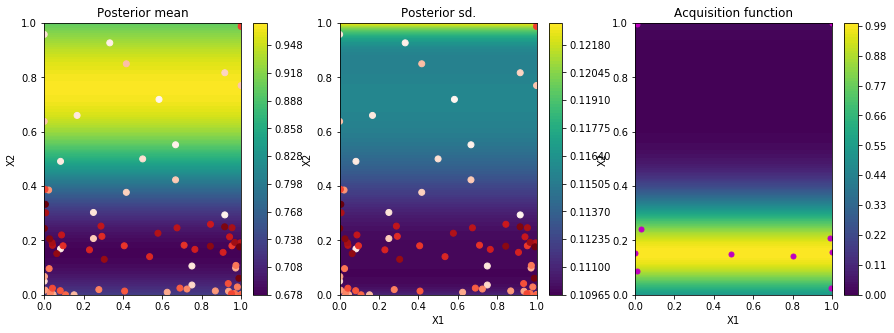

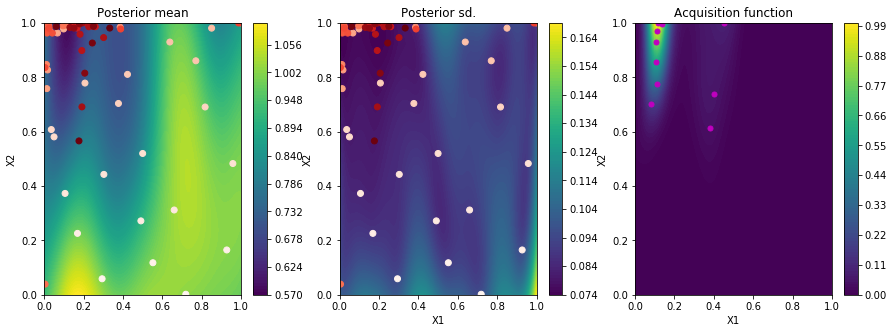

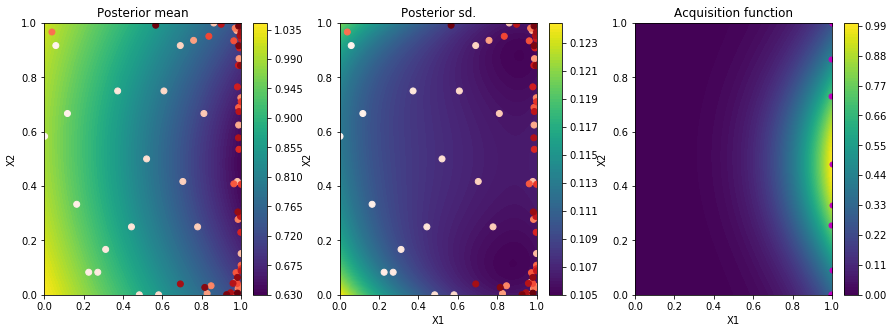

 Regular BO Batch Update 8 


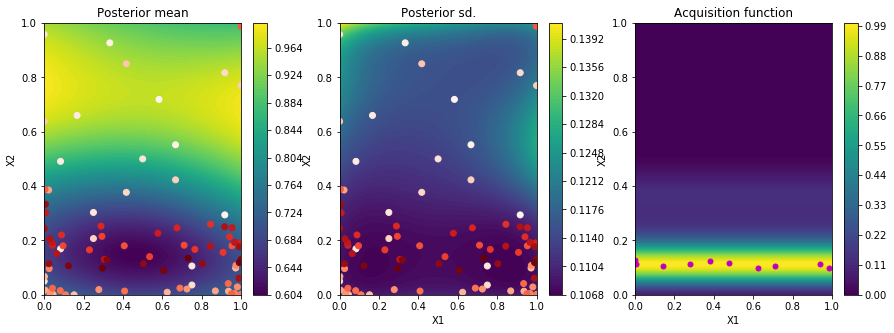

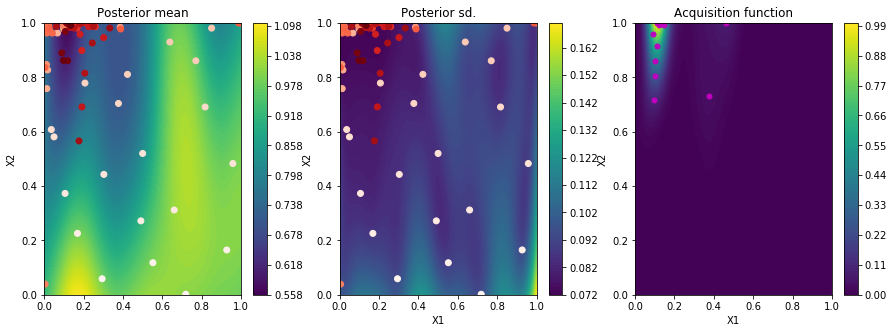

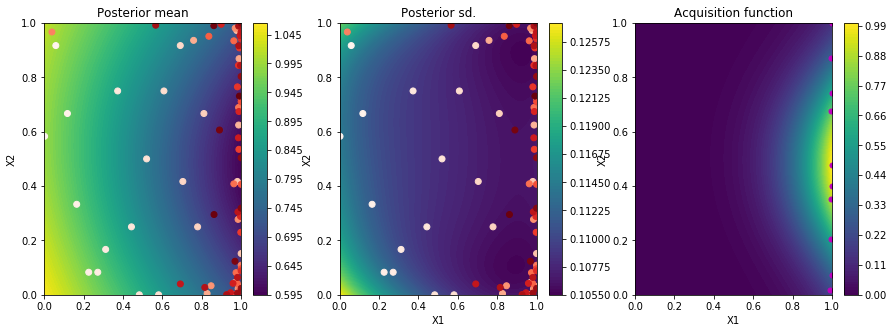

 Regular BO Batch Update 9 


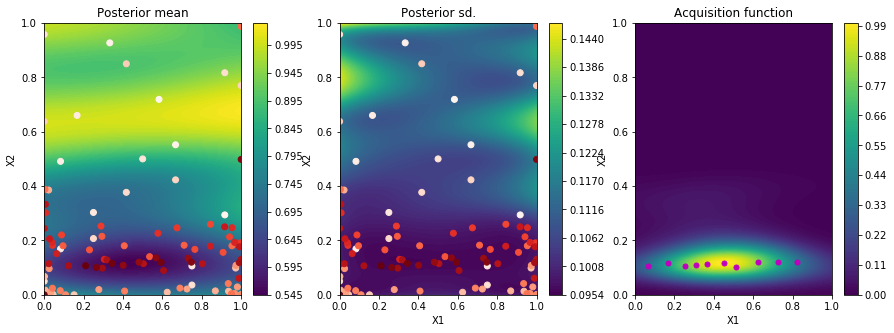

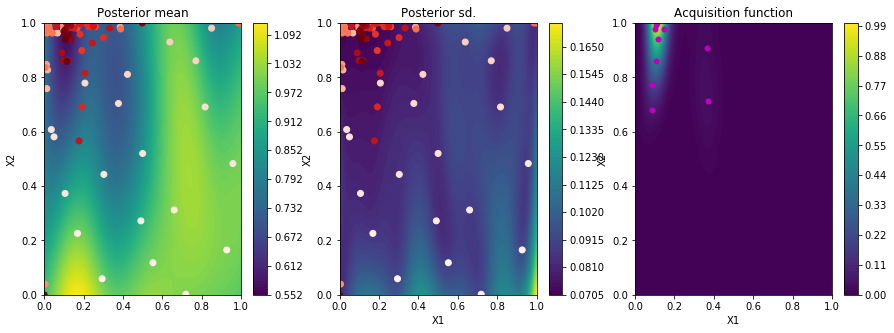

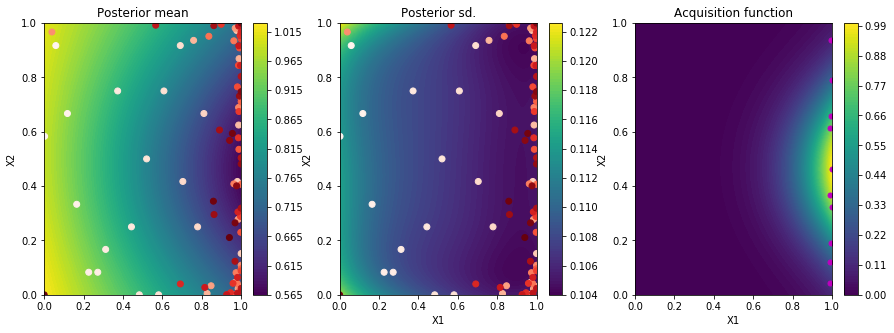

 Regular BO Batch Update 10 


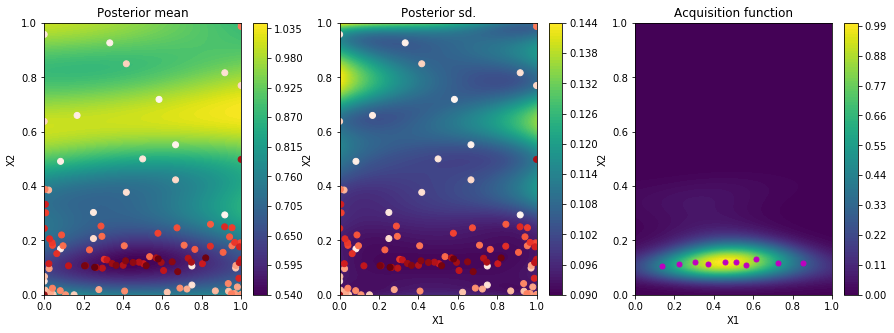

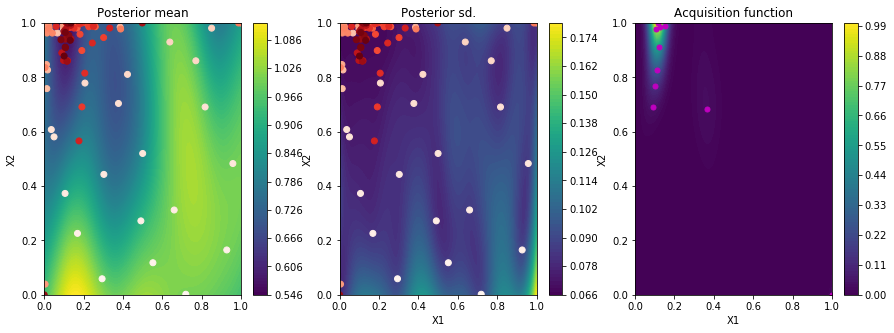

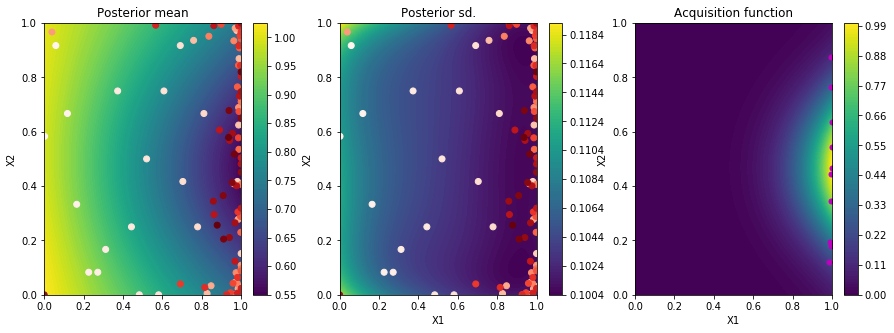

In [17]:
# Begin loop
# assign variables
x_conds_reg=[x_conds[0]]
y_obj_reg=[y_obj[0]]
acq_2Ds_reg=[]
Xp = x_conds_reg[0][:,0] # pressure
Xf = x_conds_reg[0][:,1] # frequency
Xs = x_conds_reg[0][:,2] # speed
Yo = y_obj_reg[0] # objective value
for i in range(10):
    print('','='*30,'\n Regular BO Batch Update '+str(i+1),'\n','='*30)
    # ==================================================================================
    # Run BO batch
    acq_2Ds_reg.append(output_acquisition_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get 2D acquisition slices soley for plotting cubes
    x_conds_reg.append(run_BO_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get new x-condition optima
    # ==================================================================================
    # get interpolation field of objective value and droplet counts
    y_obj_reg.append(interp_values(x_predict = x_conds_reg[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
    # assign variables
    Xp = np.concatenate((Xp, x_conds_reg[i+1][:,0])) # pressure
    Xf = np.concatenate((Xf, x_conds_reg[i+1][:,1])) # frequency
    Xs = np.concatenate((Xs, x_conds_reg[i+1][:,2])) # speed
    Yo = np.concatenate((Yo, y_obj_reg[i+1])) # objective value

# Plotting

In [18]:
# save figures to this directory
impath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/07_Figure_Graphs/Working_Folder/'

In [19]:
Y_OBJ = y_obj[0]
Y_OBJ_R = y_obj_reg[0]
# unravel the appended lists
for i in range(len(y_obj)-1):
    Y_OBJ = np.concatenate((Y_OBJ,y_obj[i+1]))
    Y_OBJ_R = np.concatenate((Y_OBJ_R,y_obj_reg[i+1]))
# get running minimum
run_min_constr=[1]
run_min_reg=[1]
for i in range(len(Y_OBJ)):
    # constraint function running minimum
    if Y_OBJ[i] <= run_min_constr[i]:
        run_min_constr.append(Y_OBJ[i])
    else:
        run_min_constr.append(run_min_constr[i])
    # regular BO running minimum
    if Y_OBJ_R[i] <= run_min_reg[i]:
        run_min_reg.append(Y_OBJ_R[i])
    else:
        run_min_reg.append(run_min_reg[i])

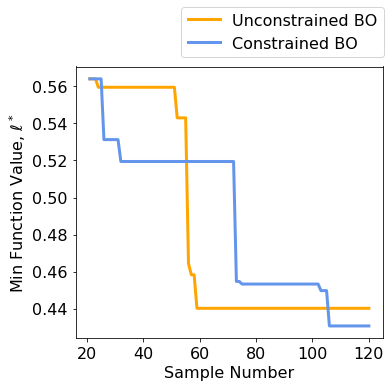

In [20]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5,5))
x_plot = np.arange(1,len(Y_OBJ)+1,1)
plt.plot(x_plot[20:],run_min_reg[21:],color='orange',linewidth=3,label='Unconstrained BO')
plt.plot(x_plot[20:],run_min_constr[21:],color='cornflowerblue',linewidth=3, label='Constrained BO')

plt.legend(prop={'size':16},bbox_to_anchor=(1.03, 1.25))
plt.ylabel('Min Function Value, $\ell^*$',fontsize=16)
plt.xlabel('Sample Number',fontsize=16)
ax.tick_params(axis='x',labelsize=16,pad=5)
ax.tick_params(axis='y',labelsize=16,pad=5)
# plt.savefig(impath+'minfunc_rerun3_R1.png',dpi=300,bbox_inches='tight')

In [21]:
csvpath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/Constraint_function_runs/'
# np.savetxt(csvpath+'constrained_rerun3.csv',run_min_constr,delimiter=',')
# np.savetxt(csvpath+'unconstrained_rerun3.csv',run_min_reg,delimiter=',')
print('constrained',run_min_constr)
print('\n unconstrained', run_min_reg)

constrained [1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.717, 0.717, 0.717, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.519

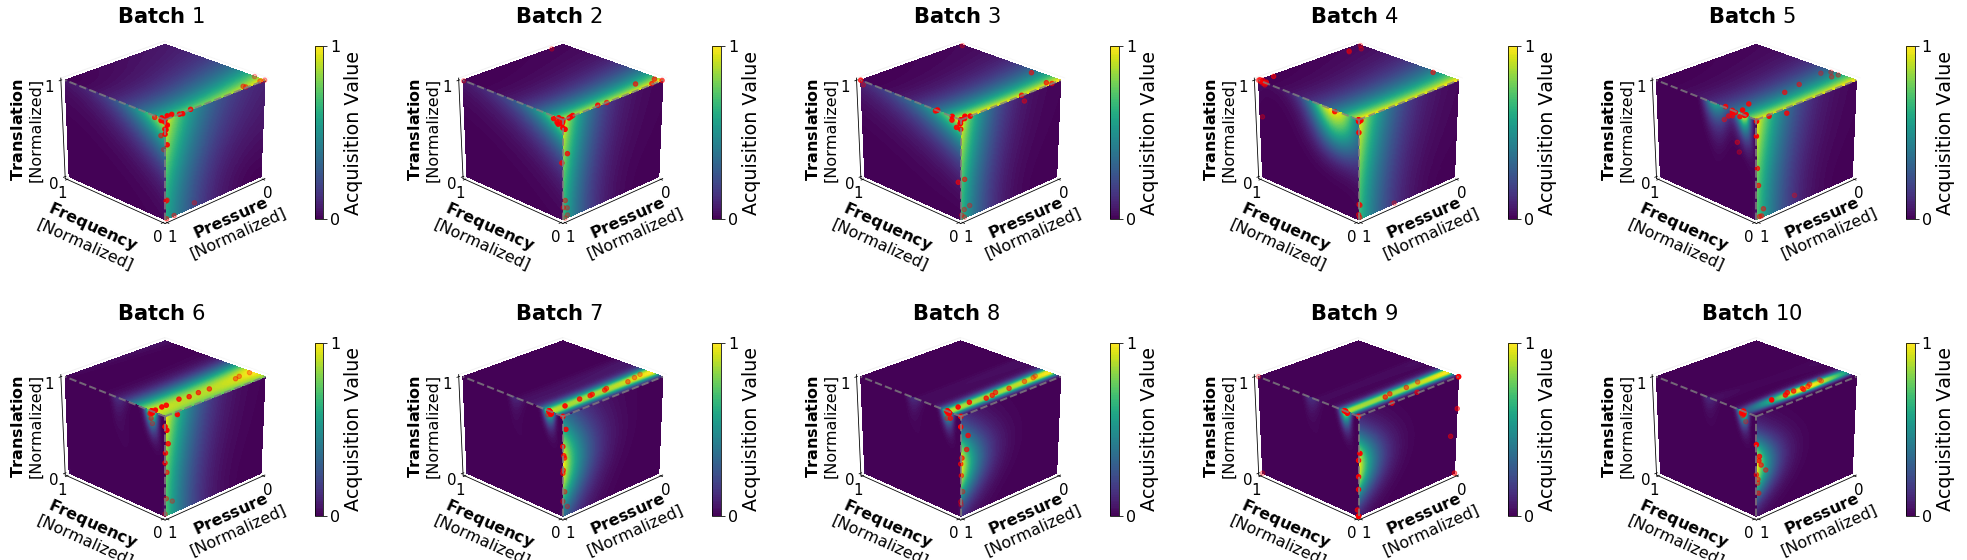

In [22]:
# Plot the constrained BO acquisition function
fs=16
fs1=15
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(35,10),)
plt.subplots_adjust(wspace=0.1)
for i in range(10):
    ii=i%5
    if i < 5:
        j=0
    else:
        j=1
    
    ax[j,ii].set_xticks([])
    ax[j,ii].set_yticks([])
    ax[j,ii].set_frame_on(False)
    # add axes
    ax[j,ii] = fig.add_subplot(2,5,1+i,projection='3d')
    ax[j,ii].plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)


    #     constraint=10
    #     surf_f0[surf_f0<constraint]=np.nan
    #     surf_f1[surf_f1<constraint]=np.nan
    #     surf_f2[surf_f2<constraint]=np.nan



    pl=ax[j,ii].contourf(XX, YY,acq_2Ds[i][0], 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='viridis', antialiased=False) # pressure-frequency
    ax[j,ii].contourf(acq_2Ds[i][1], XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='viridis', antialiased=False) # frequency-speed
    ax[j,ii].contourf(XX, acq_2Ds[i][2], YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='viridis', antialiased=False) # speed-pressure

    if i == 3:
        ax[j,ii].scatter(x_conds[i+1][:,0],1-x_conds[i+1][:,1],1,color='r') # plot p-f # there was an error
        ax[j,ii].scatter(1,1-x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot f-s # there was an error
        ax[j,ii].scatter(x_conds[i+1][:,2],0,x_conds[i+1][:,0],color='r') # plot s-p
    else:
        ax[j,ii].scatter(x_conds[i+1][:,0],x_conds[i+1][:,1],1,color='r') # plot p-f
        ax[j,ii].scatter(1,x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot f-s
        ax[j,ii].scatter(x_conds[i+1][:,2],0,x_conds[i+1][:,0],color='r') # plot s-p

#     ax.scatter(x_conds[i+1][:,0],x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot all

    ax[j,ii].grid(False)
    ax[j,ii].w_xaxis.pane.fill = False
    ax[j,ii].w_yaxis.pane.fill = False
    ax[j,ii].w_zaxis.pane.fill = False
    ax[j,ii].view_init(azim=45)
    ax[j,ii].set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].zaxis.set_rotate_label(False)
    ax[j,ii].set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)
    ax[j,ii].set_title(r'$\bf{Batch}$ '+str(i+1),fontsize=fs+5)

    ax[j,ii].set_xticks([0,1])
    ax[j,ii].set_xlim([0,1])
    ax[j,ii].set_yticks([0,1])
    ax[j,ii].set_ylim([1,0])
    ax[j,ii].set_zticks([0,1])
    ax[j,ii].set_zlim([0,1])
    ax[j,ii].tick_params(axis='z',labelsize=fs1,pad=0)
    ax[j,ii].tick_params(axis='x',labelsize=fs1,pad=-1)
    ax[j,ii].tick_params(axis='y',labelsize=fs1,pad=-1)
    ax[j,ii].zaxis.labelpad = 5
    ax[j,ii].xaxis.labelpad = 4
    ax[j,ii].yaxis.labelpad = 14
    ax[j,ii].set_frame_on(False)
    ax[j,ii].dist=12


    cbar=plt.colorbar(pl,shrink=0.7,pad=0,ax=ax[j,ii])
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_ticks([0,1])
    cbar.set_label('Acquisition Value',size=fs+3)

# plt.savefig(impath+'constrained_BO_R2.png',dpi=300,bbox_inches='tight')

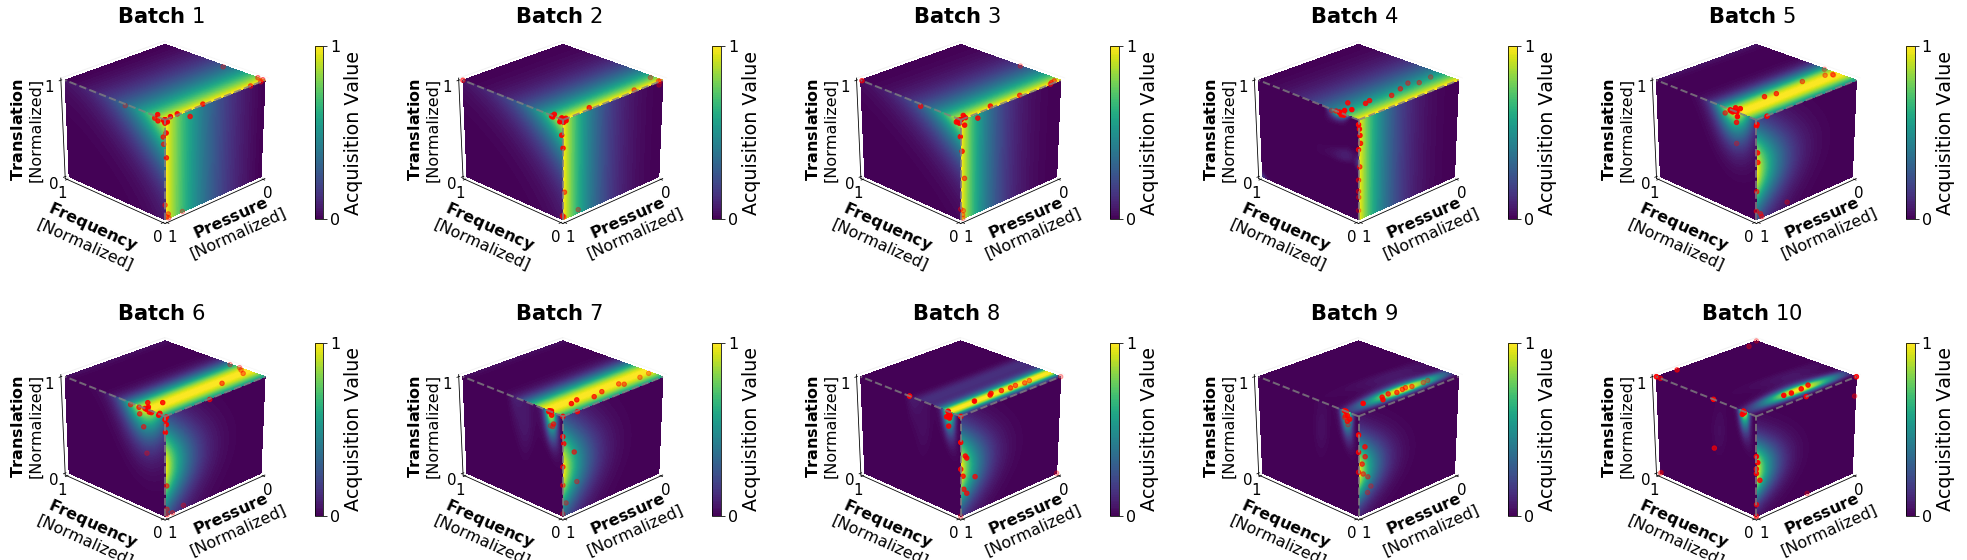

In [23]:
# Plot the unconstrained BO acquisition function
fs=16
fs1=15
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(35,10),)
plt.subplots_adjust(wspace=0.1)
for i in range(10):
    ii=i%5
    if i < 5:
        j=0
    else:
        j=1
    
    ax[j,ii].set_xticks([])
    ax[j,ii].set_yticks([])
    ax[j,ii].set_frame_on(False)
    # add axes
    ax[j,ii] = fig.add_subplot(2,5,1+i,projection='3d')
    ax[j,ii].plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)

    pl=ax[j,ii].contourf(XX, YY,acq_2Ds_reg[i][0], 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='viridis', antialiased=False) # pressure-frequency
    ax[j,ii].contourf(acq_2Ds_reg[i][1], XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='viridis', antialiased=False) # frequency-speed
    ax[j,ii].contourf(XX, acq_2Ds_reg[i][2], YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='viridis', antialiased=False) # speed-pressure


    ax[j,ii].scatter(x_conds_reg[i+1][:,0],x_conds_reg[i+1][:,1],1,color='r') # plot p-f
    ax[j,ii].scatter(1,x_conds_reg[i+1][:,1],x_conds_reg[i+1][:,2],color='r') # plot f-s
    ax[j,ii].scatter(x_conds_reg[i+1][:,2],0,x_conds_reg[i+1][:,0],color='r') # plot s-p

#     ax.scatter(x_conds[i+1][:,0],x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot all

    ax[j,ii].grid(False)
    ax[j,ii].w_xaxis.pane.fill = False
    ax[j,ii].w_yaxis.pane.fill = False
    ax[j,ii].w_zaxis.pane.fill = False
    ax[j,ii].view_init(azim=45)
    ax[j,ii].set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].zaxis.set_rotate_label(False)
    ax[j,ii].set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)
    ax[j,ii].set_title(r'$\bf{Batch}$ '+str(i+1),fontsize=fs+5)

    ax[j,ii].set_xticks([0,1])
    ax[j,ii].set_xlim([0,1])
    ax[j,ii].set_yticks([0,1])
    ax[j,ii].set_ylim([1,0])
    ax[j,ii].set_zticks([0,1])
    ax[j,ii].set_zlim([0,1])
    ax[j,ii].tick_params(axis='z',labelsize=fs1,pad=0)
    ax[j,ii].tick_params(axis='x',labelsize=fs1,pad=-1)
    ax[j,ii].tick_params(axis='y',labelsize=fs1,pad=-1)
    ax[j,ii].zaxis.labelpad = 5
    ax[j,ii].xaxis.labelpad = 4
    ax[j,ii].yaxis.labelpad = 14
    ax[j,ii].set_frame_on(False)
    ax[j,ii].dist=12


    cbar=plt.colorbar(pl,shrink=0.7,pad=0,ax=ax[j,ii])
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_ticks([0,1])
    cbar.set_label('Acquisition Value',size=fs+3)

# plt.savefig(impath+'unconstrained_BO_R1.png',dpi=300,bbox_inches='tight')

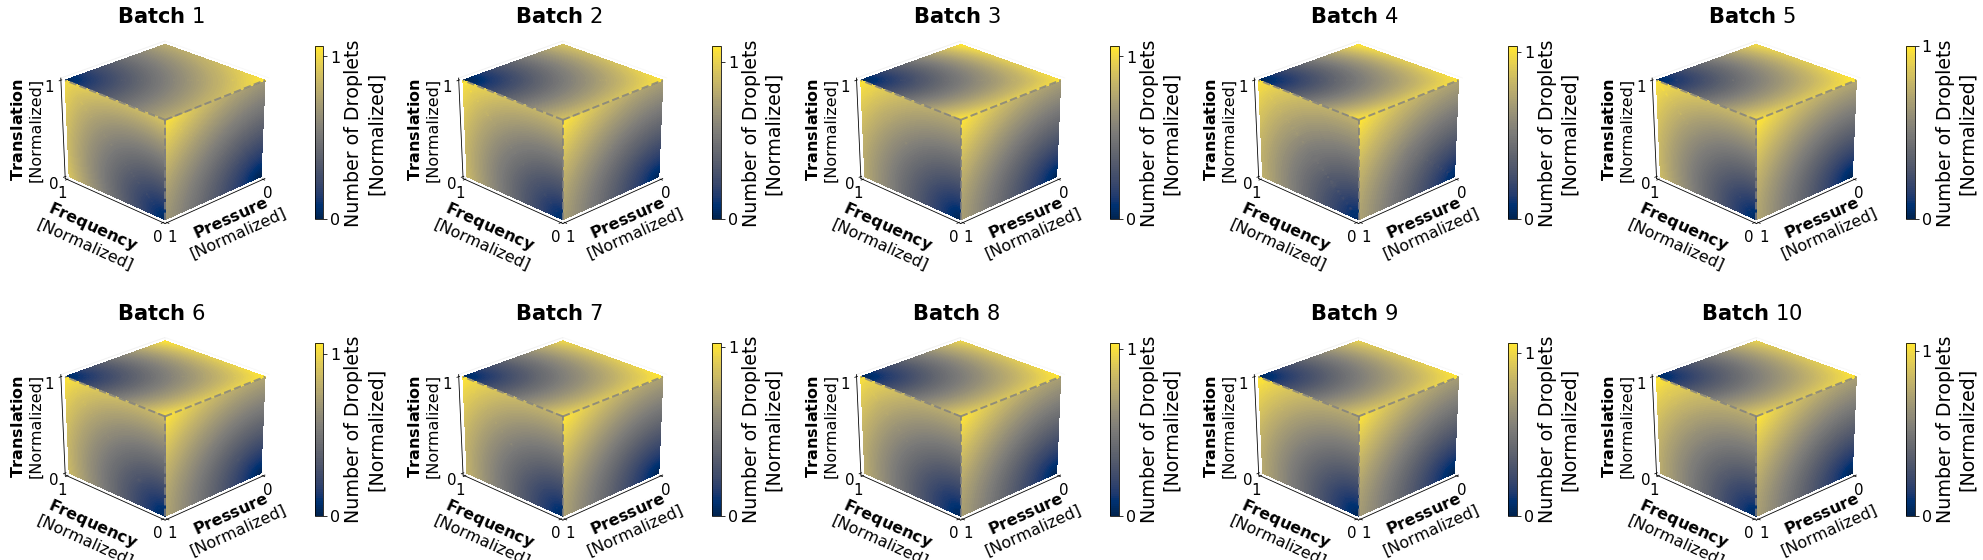

In [24]:
# Plot the number of droplets
fs=16
fs1=15
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(35,10),)
plt.subplots_adjust(wspace=0.1)
for i in range(10):
    ii=i%5
    if i < 5:
        j=0
    else:
        j=1
    
    ax[j,ii].set_xticks([])
    ax[j,ii].set_yticks([])
    ax[j,ii].set_frame_on(False)
    # add axes
    ax[j,ii] = fig.add_subplot(2,5,1+i,projection='3d')
    ax[j,ii].plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)

    pl=ax[j,ii].contourf(XX, YY,dropnum_2Ds[i][0], 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='cividis', antialiased=False) # pressure-frequency
    ax[j,ii].contourf(dropnum_2Ds[i][1], XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='cividis', antialiased=False) # frequency-speed
    ax[j,ii].contourf(XX, dropnum_2Ds[i][2], YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='cividis', antialiased=False) # speed-pressure

    ax[j,ii].grid(False)
    ax[j,ii].w_xaxis.pane.fill = False
    ax[j,ii].w_yaxis.pane.fill = False
    ax[j,ii].w_zaxis.pane.fill = False
    ax[j,ii].view_init(azim=45)
    ax[j,ii].set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].zaxis.set_rotate_label(False)
    ax[j,ii].set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)
    ax[j,ii].set_title(r'$\bf{Batch}$ '+str(i+1),fontsize=fs+5)

    ax[j,ii].set_xticks([0,1])
    ax[j,ii].set_xlim([0,1])
    ax[j,ii].set_yticks([0,1])
    ax[j,ii].set_ylim([1,0])
    ax[j,ii].set_zticks([0,1])
    ax[j,ii].set_zlim([0,1])
    ax[j,ii].tick_params(axis='z',labelsize=fs1,pad=0)
    ax[j,ii].tick_params(axis='x',labelsize=fs1,pad=-1)
    ax[j,ii].tick_params(axis='y',labelsize=fs1,pad=-1)
    ax[j,ii].zaxis.labelpad = 5
    ax[j,ii].xaxis.labelpad = 4
    ax[j,ii].yaxis.labelpad = 14
    ax[j,ii].set_frame_on(False)
    ax[j,ii].dist=12


    cbar=plt.colorbar(pl,shrink=0.7,pad=0,ax=ax[j,ii])
    cbar.ax.tick_params(labelsize=fs) 
    aa=cbar.get_ticks()
    cbar.set_ticks([aa[0],aa[len(aa)-1]])
    cbar.ax.set_yticklabels([0,1])
    cbar.set_label('Number of Droplets\n[Normalized]',size=fs+3)

# plt.savefig(impath+'num_droplets_BO_R1.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Translation\n[Normalized]')

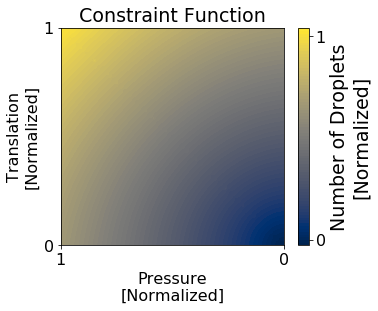

In [25]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
pl=ax.contourf(XX, YY,dropnum_2Ds[0][2], 100,alpha=1,cmap='cividis', antialiased=False) # pressure-frequency
cbar=plt.colorbar(pl,shrink=1,pad=0.05)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Number of Droplets\n[Normalized]',size=fs+3)
ax.set_xticks([0,1])
ax.set_xlim([1,0])
ax.set_yticks([0,1])
ax.tick_params(axis='both',labelsize=fs)
ax.set_title('Constraint Function',fontsize=fs+3)
ax.set_xlabel('Pressure\n[Normalized]',fontsize=fs)
ax.set_ylabel('Translation\n[Normalized]',fontsize=fs)
# plt.savefig(impath+'constraint_func_R1.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Translation\n[Normalize]')

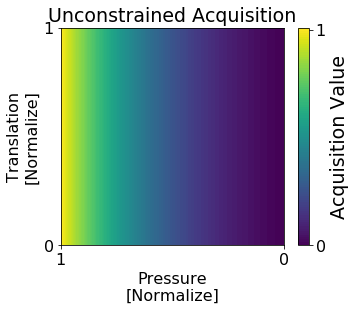

In [26]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
pl=ax.contourf(XX,YY,acq_2Ds_reg[0][2], 100,alpha=1,cmap='viridis', antialiased=False) # pressure-frequency
cbar=plt.colorbar(pl,shrink=1,pad=0.05)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Acquisition Value',size=fs+3)
ax.set_xticks([0,1])
ax.set_xlim([1,0])
ax.set_yticks([0,1])
ax.tick_params(axis='both',labelsize=fs)
ax.set_title('Unconstrained Acquisition',fontsize=fs+3)
ax.set_xlabel('Pressure\n[Normalize]',fontsize=fs)
ax.set_ylabel('Translation\n[Normalize]',fontsize=fs)
# plt.savefig(impath+'unconstrained_acq_R1.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Translation\n[Normalize]')

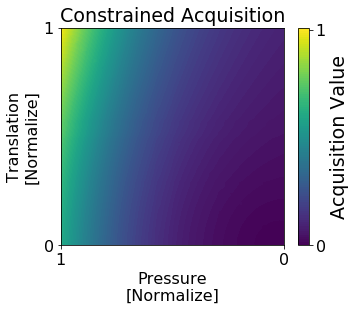

In [27]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
pl=ax.contourf(XX,YY,acq_2Ds[0][2], 100,alpha=1,cmap='viridis', antialiased=False) # pressure-frequency
cbar=plt.colorbar(pl,shrink=1,pad=0.05)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Acquisition Value',size=fs+3)
ax.set_xticks([0,1])
ax.set_xlim([1,0])
ax.set_yticks([0,1])
ax.tick_params(axis='both',labelsize=fs)
ax.set_title('Constrained Acquisition',fontsize=fs+3)
ax.set_xlabel('Pressure\n[Normalize]',fontsize=fs)
ax.set_ylabel('Translation\n[Normalize]',fontsize=fs)
# plt.savefig(impath+'constrained_acq_R1.png',dpi=300,bbox_inches='tight')

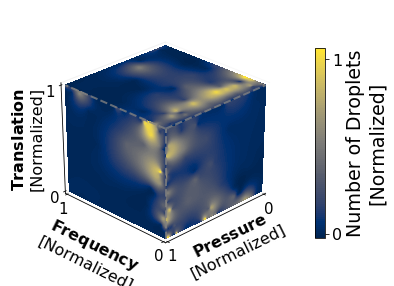

In [28]:
# plot the actual drop number
a,b,c=interp_field(x_conds=XS,y_conds=Y_cnt)
a=a(XX,YY)
b=b(XX,YY)
c=c(XX,YY)

fig,ax=plt.subplots(1,1,figsize=(6.5,5))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
# add axes
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
ax.plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
ax.plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)

pl=ax.contourf(XX, YY,a, 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='cividis', antialiased=False) # pressure-frequency
ax.contourf(b, XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='cividis', antialiased=False) # frequency-speed
ax.contourf(XX, c, YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='cividis', antialiased=False) # speed-pressure

ax.grid(False)
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.view_init(azim=45)
ax.set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
ax.set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)

ax.set_xticks([0,1])
ax.set_xlim([0,1])
ax.set_yticks([0,1])
ax.set_ylim([1,0])
ax.set_zticks([0,1])
ax.set_zlim([0,1])
ax.tick_params(axis='z',labelsize=fs1,pad=0)
ax.tick_params(axis='x',labelsize=fs1,pad=-1)
ax.tick_params(axis='y',labelsize=fs1,pad=-1)
ax.zaxis.labelpad = 5
ax.xaxis.labelpad = 4
ax.yaxis.labelpad = 14
ax.set_frame_on(False)
ax.dist=12


cbar=plt.colorbar(pl,shrink=0.7,pad=0)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Number of Droplets\n[Normalized]',size=fs+3)

# plt.savefig(impath+'actual_drop_num_R1.png',dpi=300,bbox_inches='tight')

Posterior distributions after 11 iterations.


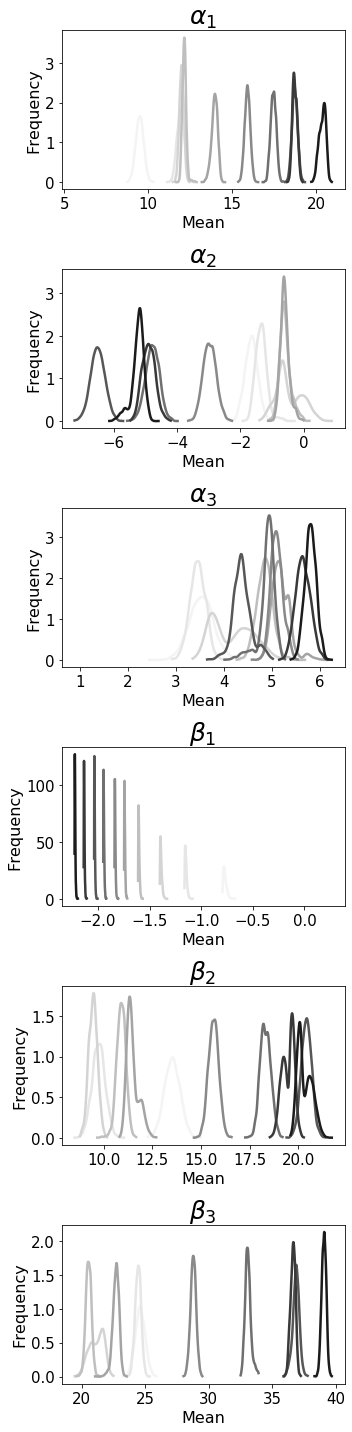

In [29]:
# plot posterior distributions of the priors after HMC sampling
print("Posterior distributions after " + str(len(traces)) + " iterations.")
import matplotlib as mpl
cmap = mpl.cm.Greys_r
fig,ax=plt.subplots(ncols=1,nrows=6,figsize=(5,20))
i=0    
parameters = [r'$\alpha_1$',r'$\alpha_2$',r'$\alpha_3$',r'$\beta_1$',r'$\beta_2$',r'$\beta_3$']
for param in ["alpha1", "alpha2", "alpha3", "beta1", "beta2",'beta3']:
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        ax[i].plot(x, y, color=cmap(1 - update_i / len(traces)),linewidth=2.5)
        ax[i].tick_params(axis='both',labelsize=15)
        ax[i].set_xlabel('Mean',fontsize=16)
        ax[i].set_ylabel('Frequency',fontsize=16)
        ax[i].set_title(parameters[i],fontsize=25)
    i+=1
plt.tight_layout()
# plt.savefig(impath+'prior_updates_R1.png',dpi=300,bbox_inches='tight')

# Run entire optimization as a batch process
Collect data on the running minimum objective value over all samples

*This code block is self-contained*

In [ ]:
# import packages
import numpy as np
import tensorflow as tf
import scipy # need scipy 1.4.1 to work with GPyOpt
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import GPy
import GPyOpt_constraints
from GPyOpt_constraints.methods import BayesianOptimization
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
from pymc3 import Model, Normal, Slice, sample, traceplot
from pymc3.distributions import Interpolated
from scipy import stats
from theano import as_op
# path imports
path='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/'
impath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/07_Figure_Graphs/Working_Folder/'
csvpath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/Constraint_function_runs/'
EI_drop_num=np.genfromtxt(path+'Dye_Set_EI_1/EI_drop_number.csv',delimiter=',')
MPI_drop_num=np.genfromtxt(path+'Dye_Set_MPI_1/MPI_drop_number.csv',delimiter=',')
LCB_drop_num=np.genfromtxt(path+'Dye_Set_LCB_1/LCB_drop_number.csv',delimiter=',')
drop_cat=np.concatenate((EI_drop_num,MPI_drop_num[20:],LCB_drop_num[20:]),axis=0)
drop_num=EI_drop_num # EI maps the cumulative of all 3 best. Plus EI has higher max droplet count than MPI (50 vs 30)
# grab all conditions + objective value + drop number
bo_full=pd.read_csv(path+'bo_full.csv',delimiter=',')
bo_full['DropCount']=drop_cat[:,3]
# create interpolation field and avoid singular matrix by removing repeating points
def interp_field(y_conds,x_conds):
    '''
    Inputs:
    xy_conds:=   Dx4 data array where the first 3 columns are pressure, frequency, speed 
                 and the 4th column are the y-values
    '''
    for n in range(3):
        cv_x_temp0=np.copy(x_conds[:,n])
        cv_x_temp1=np.copy(x_conds[:,(n+1)%3])
        cv_y_temp=np.copy(y_conds) # y condition
        for i in range(x_conds.shape[0]):
            for j in range(x_conds.shape[0]):
                if cv_x_temp0[i]==cv_x_temp0[j] and cv_x_temp1[i]==cv_x_temp1[j] and i!=j:
                    if cv_y_temp[i] < cv_y_temp[j]: # want to remove failed prints over good prints
                        cv_x_temp0[j]=np.nan
                        cv_x_temp1[j]=np.nan
                        cv_y_temp[j]=np.nan
                    else:
                        cv_x_temp0[i]=np.nan
                        cv_x_temp1[i]=np.nan
                        cv_y_temp[i]=np.nan
        cv_x_temp0=cv_x_temp0[~np.isnan(cv_x_temp0)]
        cv_x_temp1=cv_x_temp1[~np.isnan(cv_x_temp1)]
        cv_y_temp=cv_y_temp[~np.isnan(cv_y_temp)]
        globals()['rbf_'+str(n)]=Rbf(cv_x_temp0,cv_x_temp1,cv_y_temp,function='linear')
    return rbf_0, rbf_1, rbf_2
def interp_values(x_predict,y_all,x_all):
    '''
    x_predict :=    [x1,x2,x3] conditions to predict an output value
    y_all     :=    1D array of values to interpolate
    x_all     :=    Nx3 arry of conditions to use to interpolate y_all
    '''
    rbf_0,rbf_1,rbf_2=interp_field(y_conds=y_all,x_conds=x_all) # get interpolation fields in 2D slice
    val=np.array([rbf_0(x_predict[0],x_predict[1]),rbf_1(x_predict[1],x_predict[2]),rbf_2(x_predict[2],x_predict[0])]) # predict
    val = np.mean(val, axis = 0) # linearly interpolate predicted values
    val[val < 0.] = 0. # set all negative values equal to 0
    return val
# normalization function
def normalize_it(array):
    return (array - np.min(array))/((np.max(array-np.min(array))))
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition(x_conds,y_conds,constraint_function):
    '''
    Output the aquisition function so it can be augmented by the constraint function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         constraint_function=constraint_function[n,:,:],
                                         acquisition_type ='constrained_EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO(x_conds,y_conds,constraint_function):
    '''
    Implement Bayesian optimization.
    
    ** constraint_function must be a numpy array of shape (3,100,100) for 3D using three 2D surfaces
        and (100,100) for 2D.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     constraint_function=constraint_function, # must be a numpy array of three 2D surfaces with shape (3,100,100)
                                     acquisition_type ='constrained_EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next
# create new prior from the previous posteriors by interpolating the distributions
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition_reg(x_conds,y_conds):
    '''
    Output the aquisition function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         acquisition_type ='EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO_reg(x_conds,y_conds):
    '''
    Implement Bayesian optimization.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next
# Grab initialization data only
output_obj=np.array(bo_full['Objective'][:20]) # objective value
output_drops=np.array(bo_full['DropCount'][:20]) # number of droplets
pressure=np.array(bo_full['Pressure'][:20])
frequency=np.array(bo_full['Frequency'][:20])
speed=np.array(bo_full['Speed'][:20])
# start conditions lists
x_conds = [np.array([pressure,frequency,speed]).T] # X conditions
# get meshgrid for plotting
xx, yy = [np.linspace(0,1,100),np.linspace(0,1,100)] # MESH SIZE MUST BE 100X100 IN ORDER FOR CONSTRAINT FUNCTION TO WORK IN BO LOOP
XX, YY = np.meshgrid (xx,yy)
# BEGIN LOOP
for T in range(100):
    print('-------- ITERATION #'+str(T+1)+' --------')
    y_obj = [output_obj] # Objective values
    y_cnt = [output_drops] # Number of droplets
    # initialize model priors
    traces = [] # create list to append traces of priors
    init_model = Model()
    with init_model:
        # Priors for unknown model parameters
        alpha1 = pm.Normal("alpha1", mu=0, sigma=1)
        alpha2 = pm.Normal("alpha2", mu=0, sigma=1)
        alpha3 = pm.Normal("alpha3", mu=0, sigma=1)
        beta1 = pm.Gamma("beta1", alpha=0.7, beta=0.5)
        beta2 = pm.Gamma("beta2", alpha=0.7, beta=0.5)
        beta3 = pm.Gamma("beta3", alpha=0.7, beta=0.5)

        # Expected value of outcome
        mu1 = alpha1 + beta1 * pressure + beta2 * (0.7-frequency) # pressure-frequency
        mu2 = alpha2 + beta2 * (0.7-frequency) + beta3 * (speed-0.2) # frequency-speed
        mu3 = alpha3 + beta3 * (speed-0.2) + beta1 * pressure # speed-pressure

        # Likelihood (sampling distribution) of observations
        Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=y_cnt[0])
        Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=y_cnt[0])
        Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=y_cnt[0])

        # draw 1000 posterior samples using HMC
        trace = sample(1000)
        traces.append(trace)
        
    # compute simulated droplet numbers for each 2D slice
    X_sim=np.linspace(0,1,len(trace['alpha1']))
    Y_pf = trace['alpha1']+trace['beta1']*X_sim+trace['beta2']*(0.7-X_sim)
    # Y_pf_norm = normalize_it(Y_pressure_frequency) # normalize
    Y_fs = trace['alpha2']+trace['beta2']*(0.7-X_sim)+trace['beta3']*(X_sim-0.2)
    # Y_fs_norm = normalize_it(Y_frequency_speed) # normalize
    Y_sp = trace['alpha3']+trace['beta1']*X_sim+trace['beta3']*(X_sim-0.2)
    # Y_sp_norm = normalize_it(Y_speed_pressure) # normalize

    # run interpolation
    dropnum_2Ds=[]
    # pressure-frequency
    rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
    surf_f0=rbf_pf(XX,YY)
    # frequency-speed
    rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
    surf_f1=rbf_fs(XX,YY)
    # speed-pressure
    rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
    surf_f2=rbf_sp(XX,YY)
    max_norm = np.max([surf_f0,surf_f1,surf_f2])
    dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))
    
    # RUN BO and get the new 10 output conditions using the the 20 LHS initialized conditions, objective values, and constraints
    acq_2Ds=[] # list of acquisition function spaces
    acq_2Ds.append(output_acquisition(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))
    x_conds.append(run_BO(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))
    
    # all condition values
    XS=np.array(bo_full[['Pressure','Frequency','Speed']])
    Y_obj=np.array(bo_full['Objective'])
    Y_cnt=np.array(bo_full['DropCount'])
    # Begin loop
    # assign variables
    Xp = x_conds[0][:,0] # pressure
    Xf = x_conds[0][:,1] # frequency
    Xs = x_conds[0][:,2] # speed
    Yo = y_obj[0] # objective value
    Yc = y_cnt[0] # droplet count
    for i in range(10):
        print('','='*30,'\n BO + Constraints Batch Update '+str(i+1),'\n','='*30)
        # ==================================================================================
        # get interpolation field of objective value and droplet counts
        y_obj.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
        y_cnt.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_cnt, x_all = XS)) # use first batch after initilization
        # assign variables from first update
        Xp = np.concatenate((Xp, x_conds[i+1][:,0])) # pressure
        Xf = np.concatenate((Xf, x_conds[i+1][:,1])) # frequency
        Xs = np.concatenate((Xs, x_conds[i+1][:,2])) # speed
        Yo = np.concatenate((Yo, y_obj[i+1])) # objective value
        Yc = np.concatenate((Yc, y_cnt[i+1])) # droplet count
        # ==================================================================================
        # get new HMC estimations of droplet count priors to learn the constraint with the new y_cnt data from previous batch
        update_model = Model()
        with update_model:
            # Priors are posteriors from previous iteration
            alpha1 = from_posterior("alpha1", traces[i]["alpha1"])
            alpha2 = from_posterior("alpha2", traces[i]["alpha2"])
            alpha3 = from_posterior("alpha3", traces[i]["alpha3"])
            beta1 = from_posterior("beta1", traces[i]["beta1"])
            beta2 = from_posterior("beta2", traces[i]["beta2"])
            beta3 = from_posterior("beta3", traces[i]["beta3"])

            # Expected value of outcome
            mu1 = alpha1 + beta1 * Xp + beta2 * (0.7-Xf) # pressure-frequency
            mu2 = alpha2 + beta2 * (0.7-Xf) + beta3 * (Xs-0.2) # frequency-speed
            mu3 = alpha3 + beta3 * (Xs-0.2) + beta1 * Xp # speed-pressure

            # Likelihood (sampling distribution) of observations
            Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=Yc) # observed droplet count
            Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=Yc) # observed droplet count
            Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=Yc) # observed droplet count

            # draw 10000 posterior samples
            trace = sample(1000)
            traces.append(trace)
        # ==================================================================================
        # compute simulated droplet numbers for each 2D slice
        Y_pf = traces[i+1]['alpha1']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta2']*(0.7-X_sim)
    #     Y_pf_norm = normalize_it(Y_pressure_frequency)
        Y_fs = traces[i+1]['alpha2']+traces[i+1]['beta2']*(0.7-X_sim)+traces[i+1]['beta3']*(X_sim-0.2)
    #     Y_fs_norm = normalize_it(Y_frequency_speed)
        Y_sp = traces[i+1]['alpha3']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta3']*(X_sim-0.2)
    #     Y_sp_norm = normalize_it(Y_speed_pressure)
        # run interpolation
        # pressure-frequency
        rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
        surf_f0=rbf_pf(XX,YY)
        # frequency-speed
        rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
        surf_f1=rbf_fs(XX,YY)
        # speed-pressure
        rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
        surf_f2=rbf_sp(XX,YY)
        max_norm = np.max([surf_f0,surf_f1,surf_f2])
        dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))
        # ==================================================================================
        # Run BO batch
        acq_2Ds.append(output_acquisition(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get 2D acquisition slices soley for plotting cubes
        x_conds.append(run_BO(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get new x-condition optima
        
    # Begin loop
    # assign variables
    x_conds_reg=[x_conds[0]]
    y_obj_reg=[y_obj[0]]
    acq_2Ds_reg=[]
    Xp = x_conds_reg[0][:,0] # pressure
    Xf = x_conds_reg[0][:,1] # frequency
    Xs = x_conds_reg[0][:,2] # speed
    Yo = y_obj_reg[0] # objective value
    for i in range(10):
        print('','='*30,'\n Regular BO Batch Update '+str(i+1),'\n','='*30)
        # ==================================================================================
        # Run BO batch
        acq_2Ds_reg.append(output_acquisition_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get 2D acquisition slices soley for plotting cubes
        x_conds_reg.append(run_BO_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get new x-condition optima
        # ==================================================================================
        # get interpolation field of objective value and droplet counts
        y_obj_reg.append(interp_values(x_predict = x_conds_reg[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
        # assign variables
        Xp = np.concatenate((Xp, x_conds_reg[i+1][:,0])) # pressure
        Xf = np.concatenate((Xf, x_conds_reg[i+1][:,1])) # frequency
        Xs = np.concatenate((Xs, x_conds_reg[i+1][:,2])) # speed
        Yo = np.concatenate((Yo, y_obj_reg[i+1])) # objective value
        
    Y_OBJ = y_obj[0]
    Y_OBJ_R = y_obj_reg[0]
    # unravel the appended lists
    for i in range(len(y_obj)-1):
        Y_OBJ = np.concatenate((Y_OBJ,y_obj[i+1]))
        Y_OBJ_R = np.concatenate((Y_OBJ_R,y_obj_reg[i+1]))
    # get running minimum
    run_min_constr=[1]
    run_min_reg=[1]
    for i in range(len(Y_OBJ)):
        # constraint function running minimum
        if Y_OBJ[i] <= run_min_constr[i]:
            run_min_constr.append(Y_OBJ[i])
        else:
            run_min_constr.append(run_min_constr[i])
        # regular BO running minimum
        if Y_OBJ_R[i] <= run_min_reg[i]:
            run_min_reg.append(Y_OBJ_R[i])
        else:
            run_min_reg.append(run_min_reg[i])
            
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5,5))
    x_plot = np.arange(1,len(Y_OBJ)+1,1)
    plt.plot(x_plot[20:],run_min_reg[21:],color='orange',linewidth=3,label='Unconstrained BO')
    plt.plot(x_plot[20:],run_min_constr[21:],color='cornflowerblue',linewidth=3, label='Constrained BO')

    plt.legend(prop={'size':16},bbox_to_anchor=(1.03, 1.25))
    plt.ylabel('Min Function Value, $\ell^*$',fontsize=16)
    plt.xlabel('Sample Number',fontsize=16)
    ax.tick_params(axis='x',labelsize=16,pad=5)
    ax.tick_params(axis='y',labelsize=16,pad=5)
    plt.savefig(impath+'minfunc_rerun'+str(T+5)+'_R1.png',dpi=300,bbox_inches='tight')
    
    np.savetxt(csvpath+'constrained_rerun'+str(T+5)+'.csv',run_min_constr,delimiter=',')
    np.savetxt(csvpath+'unconstrained_rerun'+str(T+5)+'.csv',run_min_reg,delimiter=',')
    print('constrained',run_min_constr)
    print('\n unconstrained', run_min_reg)

### Plot divergence evaluations

In [30]:
NUTS = pm.sample(10000, tune=10000, cores=1,model=init_model,init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 43 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
divergences=NUTS['diverging']
divergences=divergences.astype(int)
tuning=pd.DataFrame(np.zeros((len(divergences),6)),columns=[r'$\alpha$',r'$\beta$',r'$\gamma$',r'$\delta$',r'$\sigma$','Divergences'])
tuning[r'$\alpha$']=NUTS['alpha']
tuning[r'$\beta$']=NUTS['beta']
tuning[r'$\gamma$']=NUTS['gamma']
tuning[r'$\delta$']=NUTS['delta']
tuning[r'$\sigma$']=NUTS['sigma']
tuning['Divergences']=divergences

KeyError: 'Unknown variable alpha'

In [ ]:
import plotly.graph_objects as go
w=800
h=400
layout = plotly.graph_objs.Layout(
    autosize=True,
    width=w,
    height=h,
    paper_bgcolor = 'white',
    #plot_bgcolor = '#080808',
    
    #title=dict(text='TE Design Space Exploration',font=dict(color=labcol)),
)

fig = go.Figure(layout=layout,data=
    go.Parcoords(
        line = dict(color = tuning['Divergences'],
                   colorscale = [[0,'rgba(10,10,10,.3)'],[1,'rgba(255,0,0,0)']]),       
        labelfont=dict(size=30),
        rangefont=dict(size=18),
        tickfont=dict(color='white',size=1), # make nearly invisible
        dimensions = list([
            dict(label = '\u03B1', values = tuning[r'$\alpha$']),
            dict(label = '\u03B2', values = tuning[r'$\beta$']),
            dict(label = '\u03B3', values = tuning[r'$\gamma$']),
            dict(label = '\u03B4', values = tuning[r'$\delta$']),
            dict(label = '\u03C3', values = tuning[r'$\sigma$']),])
    )
)

fig.show()